## CS5187 Project code V2 ##

```sh
conda install -c conda-forge dataset
conda install -c conda-forge transformers=4.26.1
conda install -c conda-forge evaluate
conda install -c conda-forge albumentations
conda install -c conda-forge torchmetrics
```

In [1]:
from datasets import load_dataset
from huggingface_hub import hf_hub_download
from transformers import BeitImageProcessor, MaskFormerImageProcessor, SegformerImageProcessor, BeitForSemanticSegmentation, MaskFormerForInstanceSegmentation, SegformerForSemanticSegmentation, TrainingArguments, Trainer, pipeline
from torchvision.transforms import ColorJitter
import evaluate
from torchmetrics import Dice

import torch
import numpy as np
from torch import nn
import json
import matplotlib.pyplot as plt
import colorsys
import random
import os

In [2]:
g_dataset = "scene_parse_150"
g_pretrain_1 = "microsoft/beit-base-finetuned-ade-640-640"
g_pretrain_2 = "nvidia/segformer-b5-finetuned-ade-640-640"

g_label_repo_id = "huggingface/label-files"
g_label_filename = "ade20k-id2label.json"

g_modeldir_1 = "output/beit-base-scene-parse-150"
g_modeldir_2 = "output/segformer-b5-scene-parse-150"
g_logdir_1 = "logs/beit-base-scene-parse-150"
g_logdir_2 = "logs/segformer-b5-scene-parse-150"

g_trained_model = None #"output/segformer-b5-scene-parse-150/checkpoint-1000"
g_result_json_1 = "output/scores-beit-base-ade.json"
g_result_json_2 = "output/scores-segformer-b5-scene-parse-150.json"
g_result_json_3 = "output/scores-mixed.json"

In [3]:
g_device = torch.device("cuda" if torch.cuda.is_available() else "cpu")  # use GPU if available, otherwise use a CPU
g_seed = 5187 * 5187

In [4]:
os.makedirs(os.path.dirname("output/"), exist_ok=True)  
os.makedirs(os.path.dirname("logs/"), exist_ok=True)  

In [5]:
def set_random_seed(seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)

set_random_seed(g_seed)

In [6]:
ds = load_dataset(g_dataset, split="train[:1000]")

No config specified, defaulting to: scene_parse_150/scene_parsing
Found cached dataset scene_parse_150 (C:/Users/User/.cache/huggingface/datasets/scene_parse_150/scene_parsing/1.0.0/d998c54e1b5c5bad12b4d2ec7e1a5f74eee4c153bc1b089a0001677ae9b3fd75)


In [7]:
ds1 = ds.train_test_split(test_size=0.1)
train_ds1 = ds1["train"]
test_ds1 = ds1["test"]
ds2 = ds.train_test_split(test_size=0.1)
train_ds2 = ds2["train"]
test_ds2 = ds2["test"]

Loading cached split indices for dataset at C:\Users\User\.cache\huggingface\datasets\scene_parse_150\scene_parsing\1.0.0\d998c54e1b5c5bad12b4d2ec7e1a5f74eee4c153bc1b089a0001677ae9b3fd75\cache-8678ddda9d49331a.arrow and C:\Users\User\.cache\huggingface\datasets\scene_parse_150\scene_parsing\1.0.0\d998c54e1b5c5bad12b4d2ec7e1a5f74eee4c153bc1b089a0001677ae9b3fd75\cache-e7846b9c26425e7e.arrow
Loading cached split indices for dataset at C:\Users\User\.cache\huggingface\datasets\scene_parse_150\scene_parsing\1.0.0\d998c54e1b5c5bad12b4d2ec7e1a5f74eee4c153bc1b089a0001677ae9b3fd75\cache-b4ee408792e501a8.arrow and C:\Users\User\.cache\huggingface\datasets\scene_parse_150\scene_parsing\1.0.0\d998c54e1b5c5bad12b4d2ec7e1a5f74eee4c153bc1b089a0001677ae9b3fd75\cache-32e8b7b44c77e30e.arrow


In [8]:
len(train_ds1)

900

In [9]:
test_ds1_annotation = [d['annotation'] for d in test_ds1]

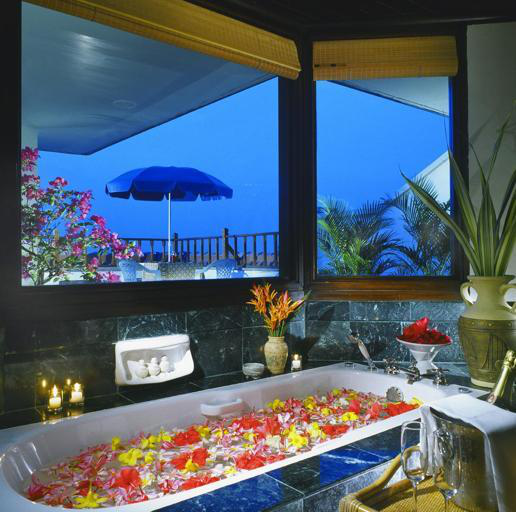

In [10]:
train_ds1[0]["image"]

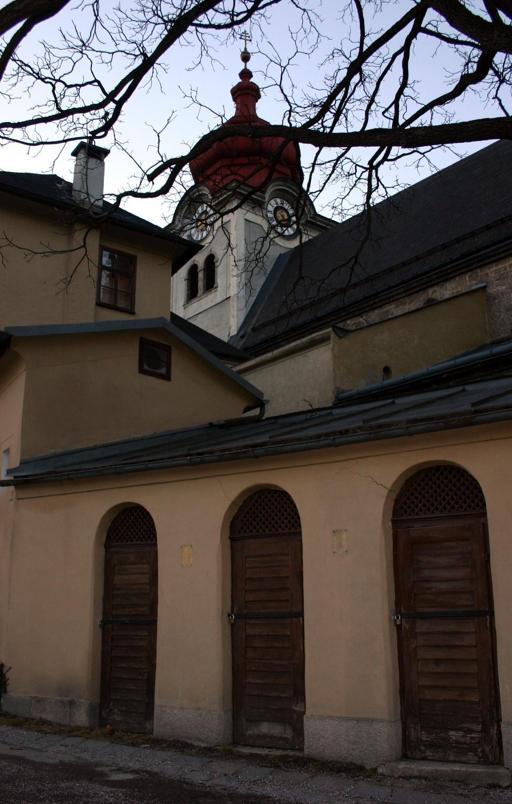

In [11]:
train_ds2[0]["image"]

In [12]:
id2label = json.load(open(hf_hub_download(repo_id=g_label_repo_id, filename=g_label_filename, repo_type="dataset"), "r"))
id2label = {int(k): v for k, v in id2label.items()}
label2id = {v: k for k, v in id2label.items()}
num_labels = len(id2label)

In [13]:
image_processor_1 = BeitImageProcessor.from_pretrained(g_pretrain_1, do_reduce_labels=True)
image_processor_2 = SegformerImageProcessor.from_pretrained(g_pretrain_2, do_reduce_labels=True)

c:\ProgramData\Miniconda3\envs\anifusion2-env\lib\site-packages\transformers\models\segformer\image_processing_segformer.py:102: FutureWarning: The `reduce_labels` parameter is deprecated and will be removed in a future version. Please use `do_reduce_labels` instead.
  warnings.warn(


In [14]:
jitter = ColorJitter(brightness=0.25, contrast=0.25, saturation=0.25, hue=0.1)

In [15]:
def train_transforms_1(example_batch):
    images = [jitter(x) for x in example_batch["image"]]
    labels = [x for x in example_batch["annotation"]]
    inputs = image_processor_1(images, labels)
    return inputs

def val_transforms_1(example_batch):
    images = [x for x in example_batch["image"]]
    labels = [x for x in example_batch["annotation"]]
    inputs = image_processor_1(images, labels)
    return inputs

def train_transforms_2(example_batch):
    images = [jitter(x) for x in example_batch["image"]]
    labels = [x for x in example_batch["annotation"]]
    inputs = image_processor_2(images, labels)
    return inputs

def val_transforms_2(example_batch):
    images = [x for x in example_batch["image"]]
    labels = [x for x in example_batch["annotation"]]
    inputs = image_processor_2(images, labels)
    return inputs

In [16]:
train_ds1.set_transform(train_transforms_1)
test_ds1.set_transform(val_transforms_1)
train_ds2.set_transform(train_transforms_2)
test_ds2.set_transform(val_transforms_2)

In [17]:
metric_iou = evaluate.load("mean_iou")
metric_dice = Dice(average='micro')

In [18]:
def compute_metrics(eval_pred):
    with torch.no_grad():
        logits, labels = eval_pred
        logits_tensor = torch.from_numpy(logits)
        logits_tensor = nn.functional.interpolate(
            logits_tensor,
            size=labels.shape[-2:],
            mode="bilinear",
            align_corners=False,
        ).argmax(dim=1)

        pred_labels = logits_tensor.detach().cpu().numpy()
        metrics_iou = metric_iou.compute(
            predictions=pred_labels,
            references=labels,
            num_labels=num_labels,
            ignore_index=255,
            reduce_labels=False,
        )
        #metrics_dice = metric_dice(pred_labels, labels)

        for key, value in metrics_iou.items():
            if type(value) is np.ndarray:
                metrics_iou[key] = value.tolist()

        return metrics_iou #, metrics_dice

In [19]:
model_1 = BeitForSemanticSegmentation.from_pretrained(g_pretrain_1, id2label=id2label, label2id=label2id, ignore_mismatched_sizes=True)

In [20]:
model_2 = SegformerForSemanticSegmentation.from_pretrained(g_pretrain_2, id2label=id2label, label2id=label2id)

In [21]:
def get_training_args(output_dir, logging_dir, batch_size):
    return TrainingArguments (
        output_dir=output_dir,
        logging_dir=logging_dir,
        optim="adamw_torch",
        learning_rate=1e-6,
        num_train_epochs=10,
        per_device_train_batch_size=batch_size,
        per_device_eval_batch_size=batch_size,
        save_total_limit=2,
        evaluation_strategy="steps",
        save_strategy="steps",
        save_steps=450,
        eval_steps=450,
        logging_steps=1,
        eval_accumulation_steps=5,
        remove_unused_columns=False,
        push_to_hub=False,
        report_to="all"
    )

trainer_1 = Trainer(
    model=model_1,
    args=get_training_args(g_modeldir_1, g_logdir_1, 1),
    train_dataset=train_ds1,
    eval_dataset=test_ds1,
    compute_metrics=compute_metrics,
)

trainer_2 = Trainer(
    model=model_2,
    args=get_training_args(g_modeldir_2, g_logdir_2, 1),
    train_dataset=train_ds2,
    eval_dataset=test_ds2,
    compute_metrics=compute_metrics,
)

PyTorch: setting up devices


In [22]:
#Model too large!
#trainer_1.train()

In [23]:
if g_trained_model is None:
    #41m20.3s
    trainer_2.train()
else:
    model_2 = SegformerForSemanticSegmentation.from_pretrained(g_trained_model, id2label=id2label, label2id=label2id)

***** Running training *****
  Num examples = 900
  Num Epochs = 10
  Instantaneous batch size per device = 1
  Total train batch size (w. parallel, distributed & accumulation) = 1
  Gradient Accumulation steps = 1
  Total optimization steps = 9000
  Number of trainable parameters = 84708694


  0%|          | 0/9000 [00:00<?, ?it/s]

{'loss': 0.1612, 'learning_rate': 9.99888888888889e-07, 'epoch': 0.0}
{'loss': 0.2272, 'learning_rate': 9.997777777777777e-07, 'epoch': 0.0}
{'loss': 0.1858, 'learning_rate': 9.996666666666667e-07, 'epoch': 0.0}
{'loss': 0.2074, 'learning_rate': 9.995555555555555e-07, 'epoch': 0.0}
{'loss': 0.2664, 'learning_rate': 9.994444444444445e-07, 'epoch': 0.01}
{'loss': 0.1616, 'learning_rate': 9.993333333333333e-07, 'epoch': 0.01}
{'loss': 0.2397, 'learning_rate': 9.99222222222222e-07, 'epoch': 0.01}
{'loss': 0.2504, 'learning_rate': 9.99111111111111e-07, 'epoch': 0.01}
{'loss': 0.2641, 'learning_rate': 9.989999999999999e-07, 'epoch': 0.01}
{'loss': 0.3844, 'learning_rate': 9.988888888888889e-07, 'epoch': 0.01}
{'loss': 0.2469, 'learning_rate': 9.987777777777777e-07, 'epoch': 0.01}
{'loss': 0.1493, 'learning_rate': 9.986666666666667e-07, 'epoch': 0.01}
{'loss': 0.1587, 'learning_rate': 9.985555555555554e-07, 'epoch': 0.01}
{'loss': 0.1468, 'learning_rate': 9.984444444444444e-07, 'epoch': 0.02}

***** Running Evaluation *****
  Num examples = 100
  Batch size = 1


{'loss': 0.262, 'learning_rate': 9.499999999999999e-07, 'epoch': 0.5}


  0%|          | 0/100 [00:00<?, ?it/s]

C:\Users\User\.cache\huggingface\modules\evaluate_modules\metrics\evaluate-metric--mean_iou\08bc20f4f895f3caf75fb9e3fada1404bded3c3265243d05327cbb3b9326ffe9\mean_iou.py:259: RuntimeWarning: invalid value encountered in divide
  iou = total_area_intersect / total_area_union
C:\Users\User\.cache\huggingface\modules\evaluate_modules\metrics\evaluate-metric--mean_iou\08bc20f4f895f3caf75fb9e3fada1404bded3c3265243d05327cbb3b9326ffe9\mean_iou.py:260: RuntimeWarning: invalid value encountered in divide
  acc = total_area_intersect / total_area_label
Saving model checkpoint to output/segformer-b5-scene-parse-150\checkpoint-450
Configuration saved in output/segformer-b5-scene-parse-150\checkpoint-450\config.json


{'eval_loss': 0.14064353704452515, 'eval_mean_iou': 0.6826046627980874, 'eval_mean_accuracy': 0.817963830679635, 'eval_overall_accuracy': 0.9505113323734105, 'eval_per_category_iou': [0.9136839178000277, 0.9458368034921764, 0.9737983016324402, 0.9378163356719471, 0.91946942436372, 0.9467853979588463, 0.9481260584640306, 0.9539823716038981, 0.921789403284536, 0.9536691977176281, 0.8963478210499893, 0.0, 0.8683258668043128, 0.9455846763992051, 0.8676167780552642, 0.7970447800432859, 0.8462916517377285, 0.746924229510901, 0.9260289621673339, 0.7820947512019389, 0.7815157392212442, 0.8878784582472171, 0.843510969530083, 0.8989303859524022, 0.7857903544804503, 0.9070569975563041, 0.9798938432169851, 0.8841160565652698, 0.9112155982296488, 0.9754330005949626, 0.8909366487711426, nan, 0.7905650196562091, 0.903610771113831, 0.0, 0.9487074127987323, 0.7821915980563888, 0.9400487851087008, 0.8704455020675665, 0.7661631163351013, nan, 0.6641235151276498, 0.5208970062967191, 0.8410779200252885, 0.

Model weights saved in output/segformer-b5-scene-parse-150\checkpoint-450\pytorch_model.bin


{'loss': 0.1745, 'learning_rate': 9.498888888888889e-07, 'epoch': 0.5}
{'loss': 0.1785, 'learning_rate': 9.497777777777778e-07, 'epoch': 0.5}
{'loss': 0.0686, 'learning_rate': 9.496666666666666e-07, 'epoch': 0.5}
{'loss': 0.3549, 'learning_rate': 9.495555555555556e-07, 'epoch': 0.5}
{'loss': 0.2377, 'learning_rate': 9.494444444444444e-07, 'epoch': 0.51}
{'loss': 0.0587, 'learning_rate': 9.493333333333334e-07, 'epoch': 0.51}
{'loss': 0.4212, 'learning_rate': 9.492222222222222e-07, 'epoch': 0.51}
{'loss': 0.4398, 'learning_rate': 9.49111111111111e-07, 'epoch': 0.51}
{'loss': 0.0793, 'learning_rate': 9.489999999999999e-07, 'epoch': 0.51}
{'loss': 0.2548, 'learning_rate': 9.488888888888888e-07, 'epoch': 0.51}
{'loss': 0.1031, 'learning_rate': 9.487777777777778e-07, 'epoch': 0.51}
{'loss': 0.159, 'learning_rate': 9.486666666666666e-07, 'epoch': 0.51}
{'loss': 0.1387, 'learning_rate': 9.485555555555555e-07, 'epoch': 0.51}
{'loss': 1.3025, 'learning_rate': 9.484444444444444e-07, 'epoch': 0.52

***** Running Evaluation *****
  Num examples = 100
  Batch size = 1


{'loss': 0.1885, 'learning_rate': 9e-07, 'epoch': 1.0}


  0%|          | 0/100 [00:00<?, ?it/s]

C:\Users\User\.cache\huggingface\modules\evaluate_modules\metrics\evaluate-metric--mean_iou\08bc20f4f895f3caf75fb9e3fada1404bded3c3265243d05327cbb3b9326ffe9\mean_iou.py:259: RuntimeWarning: invalid value encountered in divide
  iou = total_area_intersect / total_area_union
C:\Users\User\.cache\huggingface\modules\evaluate_modules\metrics\evaluate-metric--mean_iou\08bc20f4f895f3caf75fb9e3fada1404bded3c3265243d05327cbb3b9326ffe9\mean_iou.py:260: RuntimeWarning: invalid value encountered in divide
  acc = total_area_intersect / total_area_label
Saving model checkpoint to output/segformer-b5-scene-parse-150\checkpoint-900
Configuration saved in output/segformer-b5-scene-parse-150\checkpoint-900\config.json


{'eval_loss': 0.14312732219696045, 'eval_mean_iou': 0.6811251042180773, 'eval_mean_accuracy': 0.8171224612789348, 'eval_overall_accuracy': 0.9497547561155686, 'eval_per_category_iou': [0.9104402782028037, 0.9460617667654069, 0.9739052275195199, 0.9367296436503617, 0.9215762870622564, 0.9448454787674865, 0.9480700077800035, 0.9530858783037751, 0.9191769635116641, 0.954014133149142, 0.8887004091533769, 0.0, 0.8704096127424725, 0.9481756592299193, 0.8648195016013318, 0.8067209963836665, 0.8233843986617362, 0.7528489536570205, 0.9295366999923799, 0.7872919543937821, 0.7842053307008885, 0.8940644768150426, 0.8433831980379913, 0.8991913424247324, 0.7887248897907071, 0.9086761010448353, 0.9792035123646405, 0.8847060262786324, 0.9168185187296881, 0.9759965674018698, 0.8917017605897922, nan, 0.789978101249517, 0.8966628168500395, 0.0, 0.9360751949481806, 0.7817732709308373, 0.9367650172033956, 0.8628379292353475, 0.7688188681849859, nan, 0.666545772267924, 0.4703843143102099, 0.848793544263343,

Model weights saved in output/segformer-b5-scene-parse-150\checkpoint-900\pytorch_model.bin


{'loss': 0.0763, 'learning_rate': 8.998888888888889e-07, 'epoch': 1.0}
{'loss': 0.4003, 'learning_rate': 8.997777777777777e-07, 'epoch': 1.0}
{'loss': 0.1116, 'learning_rate': 8.996666666666665e-07, 'epoch': 1.0}
{'loss': 0.5921, 'learning_rate': 8.995555555555555e-07, 'epoch': 1.0}
{'loss': 0.1505, 'learning_rate': 8.994444444444444e-07, 'epoch': 1.01}
{'loss': 0.135, 'learning_rate': 8.993333333333333e-07, 'epoch': 1.01}
{'loss': 0.1406, 'learning_rate': 8.992222222222222e-07, 'epoch': 1.01}
{'loss': 0.2956, 'learning_rate': 8.99111111111111e-07, 'epoch': 1.01}
{'loss': 0.1361, 'learning_rate': 8.99e-07, 'epoch': 1.01}
{'loss': 0.398, 'learning_rate': 8.988888888888888e-07, 'epoch': 1.01}
{'loss': 0.158, 'learning_rate': 8.987777777777778e-07, 'epoch': 1.01}
{'loss': 0.1822, 'learning_rate': 8.986666666666666e-07, 'epoch': 1.01}
{'loss': 0.1835, 'learning_rate': 8.985555555555556e-07, 'epoch': 1.01}
{'loss': 0.2603, 'learning_rate': 8.984444444444445e-07, 'epoch': 1.02}
{'loss': 0.22

***** Running Evaluation *****
  Num examples = 100
  Batch size = 1


{'loss': 0.3029, 'learning_rate': 8.499999999999999e-07, 'epoch': 1.5}


  0%|          | 0/100 [00:00<?, ?it/s]

C:\Users\User\.cache\huggingface\modules\evaluate_modules\metrics\evaluate-metric--mean_iou\08bc20f4f895f3caf75fb9e3fada1404bded3c3265243d05327cbb3b9326ffe9\mean_iou.py:259: RuntimeWarning: invalid value encountered in divide
  iou = total_area_intersect / total_area_union
C:\Users\User\.cache\huggingface\modules\evaluate_modules\metrics\evaluate-metric--mean_iou\08bc20f4f895f3caf75fb9e3fada1404bded3c3265243d05327cbb3b9326ffe9\mean_iou.py:260: RuntimeWarning: invalid value encountered in divide
  acc = total_area_intersect / total_area_label
Saving model checkpoint to output/segformer-b5-scene-parse-150\checkpoint-1350
Configuration saved in output/segformer-b5-scene-parse-150\checkpoint-1350\config.json


{'eval_loss': 0.1440584361553192, 'eval_mean_iou': 0.6957113784524398, 'eval_mean_accuracy': 0.8159754071265329, 'eval_overall_accuracy': 0.9494397590416925, 'eval_per_category_iou': [0.9105777922986417, 0.9458117429581737, 0.9745198676966572, 0.9358408080387098, 0.9214737264392062, 0.9465473817643829, 0.9496677506008766, 0.9459810332162198, 0.9188309883884777, 0.9548706688517983, 0.8888060475406333, nan, 0.869454234177264, 0.9471744772538073, 0.8637985393135947, 0.8105313212562878, 0.8502075437646635, 0.7501385406131807, 0.92571313299362, 0.7855652433117222, 0.7822709506133386, 0.8966482264887732, 0.8439176122888313, 0.9000617012485363, 0.7887006757750618, 0.9037309769268532, 0.9784214483362658, 0.8800460817074486, 0.916655443578301, 0.97504294397463, 0.8930053353152926, nan, 0.7912194872057581, 0.9081037478282452, 0.0, 0.9292239870667515, 0.779009243275135, 0.9348961355460137, 0.864413680781759, 0.7696162553144498, nan, 0.6659446687013882, 0.5401384970505257, 0.8436375143388315, 0.91

Model weights saved in output/segformer-b5-scene-parse-150\checkpoint-1350\pytorch_model.bin
Deleting older checkpoint [output\segformer-b5-scene-parse-150\checkpoint-450] due to args.save_total_limit


{'loss': 0.1838, 'learning_rate': 8.498888888888889e-07, 'epoch': 1.5}
{'loss': 0.2156, 'learning_rate': 8.497777777777777e-07, 'epoch': 1.5}
{'loss': 0.0646, 'learning_rate': 8.496666666666667e-07, 'epoch': 1.5}
{'loss': 0.1287, 'learning_rate': 8.495555555555555e-07, 'epoch': 1.5}
{'loss': 0.1558, 'learning_rate': 8.494444444444444e-07, 'epoch': 1.51}
{'loss': 0.4077, 'learning_rate': 8.493333333333334e-07, 'epoch': 1.51}
{'loss': 0.1997, 'learning_rate': 8.492222222222222e-07, 'epoch': 1.51}
{'loss': 0.138, 'learning_rate': 8.491111111111112e-07, 'epoch': 1.51}
{'loss': 0.506, 'learning_rate': 8.489999999999999e-07, 'epoch': 1.51}
{'loss': 0.1952, 'learning_rate': 8.488888888888888e-07, 'epoch': 1.51}
{'loss': 0.2135, 'learning_rate': 8.487777777777777e-07, 'epoch': 1.51}
{'loss': 0.3157, 'learning_rate': 8.486666666666666e-07, 'epoch': 1.51}
{'loss': 0.3066, 'learning_rate': 8.485555555555555e-07, 'epoch': 1.51}
{'loss': 0.1132, 'learning_rate': 8.484444444444444e-07, 'epoch': 1.52

***** Running Evaluation *****
  Num examples = 100
  Batch size = 1


{'loss': 0.1136, 'learning_rate': 8e-07, 'epoch': 2.0}


  0%|          | 0/100 [00:00<?, ?it/s]

C:\Users\User\.cache\huggingface\modules\evaluate_modules\metrics\evaluate-metric--mean_iou\08bc20f4f895f3caf75fb9e3fada1404bded3c3265243d05327cbb3b9326ffe9\mean_iou.py:259: RuntimeWarning: invalid value encountered in divide
  iou = total_area_intersect / total_area_union
C:\Users\User\.cache\huggingface\modules\evaluate_modules\metrics\evaluate-metric--mean_iou\08bc20f4f895f3caf75fb9e3fada1404bded3c3265243d05327cbb3b9326ffe9\mean_iou.py:260: RuntimeWarning: invalid value encountered in divide
  acc = total_area_intersect / total_area_label
Saving model checkpoint to output/segformer-b5-scene-parse-150\checkpoint-1800
Configuration saved in output/segformer-b5-scene-parse-150\checkpoint-1800\config.json


{'eval_loss': 0.14250759780406952, 'eval_mean_iou': 0.7029029002049839, 'eval_mean_accuracy': 0.8119075287748375, 'eval_overall_accuracy': 0.9501069501150854, 'eval_per_category_iou': [0.9116131355046708, 0.9451740841391967, 0.9741178368192359, 0.9384653653910434, 0.9221507647298128, 0.945993338265157, 0.9483924205378973, 0.9537116163972759, 0.9200839371867082, 0.9538751182191607, 0.8811052502935763, nan, 0.8707957917033322, 0.9476147285063927, 0.8629885622463528, 0.8114915582977619, 0.8536992397552383, 0.7480136408381381, 0.9267581178991943, 0.7828741395427892, 0.7822633187991781, 0.8952597488047023, 0.8464322730913683, 0.8985606087402508, 0.7979017454911962, 0.9027303475433408, 0.9805305881255248, 0.8828959586340125, 0.9154755970453619, 0.9759027861801942, 0.8964705818232852, nan, 0.7848048748865551, 0.9124862013982583, 0.0, 0.9239349474021156, 0.7832379893002808, 0.9386622707025358, 0.8781029501365986, 0.7638002202662894, nan, 0.6701169892329967, 0.5343790367226425, 0.84349271690943

Model weights saved in output/segformer-b5-scene-parse-150\checkpoint-1800\pytorch_model.bin
Deleting older checkpoint [output\segformer-b5-scene-parse-150\checkpoint-900] due to args.save_total_limit


{'loss': 0.2207, 'learning_rate': 7.998888888888889e-07, 'epoch': 2.0}
{'loss': 0.2557, 'learning_rate': 7.997777777777777e-07, 'epoch': 2.0}
{'loss': 0.0388, 'learning_rate': 7.996666666666666e-07, 'epoch': 2.0}
{'loss': 0.2524, 'learning_rate': 7.995555555555555e-07, 'epoch': 2.0}
{'loss': 0.1975, 'learning_rate': 7.994444444444443e-07, 'epoch': 2.01}
{'loss': 0.1495, 'learning_rate': 7.993333333333333e-07, 'epoch': 2.01}
{'loss': 0.2286, 'learning_rate': 7.992222222222221e-07, 'epoch': 2.01}
{'loss': 0.1488, 'learning_rate': 7.991111111111111e-07, 'epoch': 2.01}
{'loss': 0.167, 'learning_rate': 7.99e-07, 'epoch': 2.01}
{'loss': 0.0476, 'learning_rate': 7.988888888888889e-07, 'epoch': 2.01}
{'loss': 0.1729, 'learning_rate': 7.987777777777778e-07, 'epoch': 2.01}
{'loss': 0.2078, 'learning_rate': 7.986666666666666e-07, 'epoch': 2.01}
{'loss': 0.0403, 'learning_rate': 7.985555555555556e-07, 'epoch': 2.01}
{'loss': 0.1819, 'learning_rate': 7.984444444444444e-07, 'epoch': 2.02}
{'loss': 0

***** Running Evaluation *****
  Num examples = 100
  Batch size = 1


{'loss': 0.1786, 'learning_rate': 7.5e-07, 'epoch': 2.5}


  0%|          | 0/100 [00:00<?, ?it/s]

C:\Users\User\.cache\huggingface\modules\evaluate_modules\metrics\evaluate-metric--mean_iou\08bc20f4f895f3caf75fb9e3fada1404bded3c3265243d05327cbb3b9326ffe9\mean_iou.py:259: RuntimeWarning: invalid value encountered in divide
  iou = total_area_intersect / total_area_union
C:\Users\User\.cache\huggingface\modules\evaluate_modules\metrics\evaluate-metric--mean_iou\08bc20f4f895f3caf75fb9e3fada1404bded3c3265243d05327cbb3b9326ffe9\mean_iou.py:260: RuntimeWarning: invalid value encountered in divide
  acc = total_area_intersect / total_area_label
Saving model checkpoint to output/segformer-b5-scene-parse-150\checkpoint-2250
Configuration saved in output/segformer-b5-scene-parse-150\checkpoint-2250\config.json


{'eval_loss': 0.14935706555843353, 'eval_mean_iou': 0.6927529643199939, 'eval_mean_accuracy': 0.8151007401246457, 'eval_overall_accuracy': 0.947479808516162, 'eval_per_category_iou': [0.9036428181950601, 0.9458414524076963, 0.9739256863370046, 0.9366067226801889, 0.9229991828076642, 0.9402618984293611, 0.9491086197390186, 0.9483253903381776, 0.9150060759004327, 0.9553618440297198, 0.8822583775796433, nan, 0.8696832508179614, 0.9493388486149679, 0.8603464229645571, 0.8091543802765202, 0.8330683624801272, 0.7533026230631591, 0.9192987677210873, 0.7849237373091751, 0.7812406502443403, 0.8956400641188375, 0.8402111701184859, 0.8965572982703467, 0.7852721086708997, 0.9037118225392203, 0.9790477224773488, 0.8818723479550968, 0.9149143734070919, 0.974779881964699, 0.889325675650336, nan, 0.7910103135101852, 0.8883987915407855, 0.0, 0.9204811953268877, 0.7811418647278326, 0.9302488244378424, 0.8615568816020702, 0.7646977488949648, nan, 0.6650794173861464, 0.5792333567441689, 0.850008003841844,

Model weights saved in output/segformer-b5-scene-parse-150\checkpoint-2250\pytorch_model.bin
Deleting older checkpoint [output\segformer-b5-scene-parse-150\checkpoint-1350] due to args.save_total_limit


{'loss': 0.1587, 'learning_rate': 7.498888888888889e-07, 'epoch': 2.5}
{'loss': 0.2328, 'learning_rate': 7.497777777777777e-07, 'epoch': 2.5}
{'loss': 0.4676, 'learning_rate': 7.496666666666667e-07, 'epoch': 2.5}
{'loss': 0.3446, 'learning_rate': 7.495555555555555e-07, 'epoch': 2.5}
{'loss': 0.0863, 'learning_rate': 7.494444444444445e-07, 'epoch': 2.51}
{'loss': 0.2967, 'learning_rate': 7.493333333333333e-07, 'epoch': 2.51}
{'loss': 0.2369, 'learning_rate': 7.492222222222222e-07, 'epoch': 2.51}
{'loss': 0.0517, 'learning_rate': 7.49111111111111e-07, 'epoch': 2.51}
{'loss': 0.1281, 'learning_rate': 7.489999999999999e-07, 'epoch': 2.51}
{'loss': 0.4053, 'learning_rate': 7.488888888888889e-07, 'epoch': 2.51}
{'loss': 0.0616, 'learning_rate': 7.487777777777777e-07, 'epoch': 2.51}
{'loss': 0.1818, 'learning_rate': 7.486666666666666e-07, 'epoch': 2.51}
{'loss': 0.1144, 'learning_rate': 7.485555555555555e-07, 'epoch': 2.51}
{'loss': 0.4788, 'learning_rate': 7.484444444444444e-07, 'epoch': 2.5

***** Running Evaluation *****
  Num examples = 100
  Batch size = 1


{'loss': 0.1834, 'learning_rate': 7e-07, 'epoch': 3.0}


  0%|          | 0/100 [00:00<?, ?it/s]

C:\Users\User\.cache\huggingface\modules\evaluate_modules\metrics\evaluate-metric--mean_iou\08bc20f4f895f3caf75fb9e3fada1404bded3c3265243d05327cbb3b9326ffe9\mean_iou.py:259: RuntimeWarning: invalid value encountered in divide
  iou = total_area_intersect / total_area_union
C:\Users\User\.cache\huggingface\modules\evaluate_modules\metrics\evaluate-metric--mean_iou\08bc20f4f895f3caf75fb9e3fada1404bded3c3265243d05327cbb3b9326ffe9\mean_iou.py:260: RuntimeWarning: invalid value encountered in divide
  acc = total_area_intersect / total_area_label
Saving model checkpoint to output/segformer-b5-scene-parse-150\checkpoint-2700
Configuration saved in output/segformer-b5-scene-parse-150\checkpoint-2700\config.json


{'eval_loss': 0.1453322023153305, 'eval_mean_iou': 0.7028651660285158, 'eval_mean_accuracy': 0.8157064819135248, 'eval_overall_accuracy': 0.9487833637747788, 'eval_per_category_iou': [0.9080412785700283, 0.9461450358937465, 0.9746353229827385, 0.9369440158722642, 0.9238637894105738, 0.9451473861454476, 0.9460860549507517, 0.9506480736724522, 0.9171142945703533, 0.9560496784903085, 0.8771619556000003, nan, 0.8708809420144895, 0.9491514175640322, 0.8615696620504666, 0.8135347741986496, 0.8344959888385072, 0.7520935271913882, 0.9222734674126506, 0.7885323081351123, 0.7812154418417613, 0.8966699493015282, 0.8416989117154366, 0.8971193965531641, 0.7938500650809153, 0.9028954975258439, 0.9788679890029667, 0.8817486004570283, 0.9113017825985286, 0.9759691412255656, 0.8902945208971123, nan, 0.7934829907594645, 0.8985507246376812, 0.0, 0.9177067504015095, 0.7811284260500693, 0.9314450354200265, 0.8708837973742394, 0.765788899444333, nan, 0.6725206611570248, 0.5368913301662708, 0.846006923719708

Model weights saved in output/segformer-b5-scene-parse-150\checkpoint-2700\pytorch_model.bin
Deleting older checkpoint [output\segformer-b5-scene-parse-150\checkpoint-1800] due to args.save_total_limit


{'loss': 0.1852, 'learning_rate': 6.998888888888889e-07, 'epoch': 3.0}
{'loss': 0.1624, 'learning_rate': 6.997777777777778e-07, 'epoch': 3.0}
{'loss': 0.2321, 'learning_rate': 6.996666666666666e-07, 'epoch': 3.0}
{'loss': 0.552, 'learning_rate': 6.995555555555555e-07, 'epoch': 3.0}
{'loss': 0.26, 'learning_rate': 6.994444444444444e-07, 'epoch': 3.01}
{'loss': 0.1596, 'learning_rate': 6.993333333333333e-07, 'epoch': 3.01}
{'loss': 0.1478, 'learning_rate': 6.992222222222221e-07, 'epoch': 3.01}
{'loss': 0.3419, 'learning_rate': 6.991111111111111e-07, 'epoch': 3.01}
{'loss': 0.1511, 'learning_rate': 6.989999999999999e-07, 'epoch': 3.01}
{'loss': 0.215, 'learning_rate': 6.988888888888889e-07, 'epoch': 3.01}
{'loss': 0.1308, 'learning_rate': 6.987777777777778e-07, 'epoch': 3.01}
{'loss': 0.2233, 'learning_rate': 6.986666666666667e-07, 'epoch': 3.01}
{'loss': 0.1929, 'learning_rate': 6.985555555555556e-07, 'epoch': 3.01}
{'loss': 0.0712, 'learning_rate': 6.984444444444444e-07, 'epoch': 3.02}


***** Running Evaluation *****
  Num examples = 100
  Batch size = 1


{'loss': 0.264, 'learning_rate': 6.5e-07, 'epoch': 3.5}


  0%|          | 0/100 [00:00<?, ?it/s]

C:\Users\User\.cache\huggingface\modules\evaluate_modules\metrics\evaluate-metric--mean_iou\08bc20f4f895f3caf75fb9e3fada1404bded3c3265243d05327cbb3b9326ffe9\mean_iou.py:259: RuntimeWarning: invalid value encountered in divide
  iou = total_area_intersect / total_area_union
C:\Users\User\.cache\huggingface\modules\evaluate_modules\metrics\evaluate-metric--mean_iou\08bc20f4f895f3caf75fb9e3fada1404bded3c3265243d05327cbb3b9326ffe9\mean_iou.py:260: RuntimeWarning: invalid value encountered in divide
  acc = total_area_intersect / total_area_label
Saving model checkpoint to output/segformer-b5-scene-parse-150\checkpoint-3150
Configuration saved in output/segformer-b5-scene-parse-150\checkpoint-3150\config.json


{'eval_loss': 0.15137319266796112, 'eval_mean_iou': 0.7107950461522299, 'eval_mean_accuracy': 0.8219880069469313, 'eval_overall_accuracy': 0.9467126155291997, 'eval_per_category_iou': [0.9014406144094247, 0.9464284136004879, 0.9743414071374712, 0.9347669621916792, 0.9249250099659958, 0.9417748659985146, 0.950068013872379, 0.9485411682425812, 0.9140158400415477, 0.9553169103893896, 0.866676980385733, nan, 0.8721127597831784, 0.9500573287937811, 0.8616599391346628, 0.8122417497658532, 0.8344984271233834, 0.754175958261455, 0.9181857324257119, 0.7862199038281821, 0.7839559731277423, 0.8998877584271697, 0.838644161816612, 0.8953742055134833, 0.7890404850630551, 0.9047167187474436, 0.9792849101284988, 0.8783083275003297, 0.9139658978560884, 0.9757910605964911, 0.888151139066065, nan, 0.7942858615004122, 0.9059068883027663, 0.0, 0.9032359336920932, 0.7768708829388556, 0.9235468990261404, 0.8685922558394733, 0.768918842237131, nan, 0.660560309764748, 0.6072360922160532, 0.8495104895104895, 0.

Model weights saved in output/segformer-b5-scene-parse-150\checkpoint-3150\pytorch_model.bin
Deleting older checkpoint [output\segformer-b5-scene-parse-150\checkpoint-2250] due to args.save_total_limit


{'loss': 0.0919, 'learning_rate': 6.498888888888888e-07, 'epoch': 3.5}
{'loss': 0.2406, 'learning_rate': 6.497777777777778e-07, 'epoch': 3.5}
{'loss': 0.0419, 'learning_rate': 6.496666666666666e-07, 'epoch': 3.5}
{'loss': 0.1084, 'learning_rate': 6.495555555555555e-07, 'epoch': 3.5}
{'loss': 0.2679, 'learning_rate': 6.494444444444445e-07, 'epoch': 3.51}
{'loss': 0.1315, 'learning_rate': 6.493333333333333e-07, 'epoch': 3.51}
{'loss': 0.2361, 'learning_rate': 6.492222222222223e-07, 'epoch': 3.51}
{'loss': 1.4115, 'learning_rate': 6.491111111111111e-07, 'epoch': 3.51}
{'loss': 0.0829, 'learning_rate': 6.49e-07, 'epoch': 3.51}
{'loss': 0.2552, 'learning_rate': 6.488888888888888e-07, 'epoch': 3.51}
{'loss': 0.227, 'learning_rate': 6.487777777777777e-07, 'epoch': 3.51}
{'loss': 0.1495, 'learning_rate': 6.486666666666666e-07, 'epoch': 3.51}
{'loss': 0.1879, 'learning_rate': 6.485555555555555e-07, 'epoch': 3.51}
{'loss': 0.1961, 'learning_rate': 6.484444444444444e-07, 'epoch': 3.52}
{'loss': 0

***** Running Evaluation *****
  Num examples = 100
  Batch size = 1


{'loss': 0.1647, 'learning_rate': 6e-07, 'epoch': 4.0}


  0%|          | 0/100 [00:00<?, ?it/s]

C:\Users\User\.cache\huggingface\modules\evaluate_modules\metrics\evaluate-metric--mean_iou\08bc20f4f895f3caf75fb9e3fada1404bded3c3265243d05327cbb3b9326ffe9\mean_iou.py:259: RuntimeWarning: invalid value encountered in divide
  iou = total_area_intersect / total_area_union
C:\Users\User\.cache\huggingface\modules\evaluate_modules\metrics\evaluate-metric--mean_iou\08bc20f4f895f3caf75fb9e3fada1404bded3c3265243d05327cbb3b9326ffe9\mean_iou.py:260: RuntimeWarning: invalid value encountered in divide
  acc = total_area_intersect / total_area_label
Saving model checkpoint to output/segformer-b5-scene-parse-150\checkpoint-3600
Configuration saved in output/segformer-b5-scene-parse-150\checkpoint-3600\config.json


{'eval_loss': 0.14696469902992249, 'eval_mean_iou': 0.7014980751891935, 'eval_mean_accuracy': 0.8145546273722765, 'eval_overall_accuracy': 0.9482196538322094, 'eval_per_category_iou': [0.9070527687406491, 0.947066439643858, 0.9746659553002877, 0.9347183455559585, 0.924271187470304, 0.9459593321843283, 0.9479232875372806, 0.9498053945976376, 0.9158883481863664, 0.9550394968722437, 0.8681286727303096, nan, 0.8705647804024222, 0.9492224197361849, 0.8607590039171562, 0.8154972978832128, 0.8383149798986191, 0.7527428032223537, 0.9226170664834993, 0.7884014961822622, 0.7850337435490274, 0.899113090092904, 0.8425978159670148, 0.8985231115493679, 0.796406428578653, 0.9090250210018284, 0.9768937515497148, 0.879209636824939, 0.9121735358697582, 0.9754853290473343, 0.8953720256693093, nan, 0.7918757039008908, 0.8985463171339942, 0.0, 0.9078430708519668, 0.7807007123278028, 0.9249936603742549, 0.8673678060181128, 0.7646764314717566, nan, 0.6622409485081574, 0.5320264841541438, 0.8471028334925184, 

Model weights saved in output/segformer-b5-scene-parse-150\checkpoint-3600\pytorch_model.bin
Deleting older checkpoint [output\segformer-b5-scene-parse-150\checkpoint-2700] due to args.save_total_limit


{'loss': 0.1934, 'learning_rate': 5.998888888888889e-07, 'epoch': 4.0}
{'loss': 0.1491, 'learning_rate': 5.997777777777778e-07, 'epoch': 4.0}
{'loss': 0.1696, 'learning_rate': 5.996666666666666e-07, 'epoch': 4.0}
{'loss': 0.2905, 'learning_rate': 5.995555555555554e-07, 'epoch': 4.0}
{'loss': 0.1854, 'learning_rate': 5.994444444444444e-07, 'epoch': 4.01}
{'loss': 0.1232, 'learning_rate': 5.993333333333333e-07, 'epoch': 4.01}
{'loss': 0.3888, 'learning_rate': 5.992222222222222e-07, 'epoch': 4.01}
{'loss': 0.1537, 'learning_rate': 5.991111111111111e-07, 'epoch': 4.01}
{'loss': 0.1559, 'learning_rate': 5.989999999999999e-07, 'epoch': 4.01}
{'loss': 0.1187, 'learning_rate': 5.988888888888889e-07, 'epoch': 4.01}
{'loss': 0.3251, 'learning_rate': 5.987777777777777e-07, 'epoch': 4.01}
{'loss': 0.5526, 'learning_rate': 5.986666666666667e-07, 'epoch': 4.01}
{'loss': 0.3345, 'learning_rate': 5.985555555555555e-07, 'epoch': 4.01}
{'loss': 0.0594, 'learning_rate': 5.984444444444445e-07, 'epoch': 4.

***** Running Evaluation *****
  Num examples = 100
  Batch size = 1


{'loss': 0.1623, 'learning_rate': 5.5e-07, 'epoch': 4.5}


  0%|          | 0/100 [00:00<?, ?it/s]

C:\Users\User\.cache\huggingface\modules\evaluate_modules\metrics\evaluate-metric--mean_iou\08bc20f4f895f3caf75fb9e3fada1404bded3c3265243d05327cbb3b9326ffe9\mean_iou.py:259: RuntimeWarning: invalid value encountered in divide
  iou = total_area_intersect / total_area_union
C:\Users\User\.cache\huggingface\modules\evaluate_modules\metrics\evaluate-metric--mean_iou\08bc20f4f895f3caf75fb9e3fada1404bded3c3265243d05327cbb3b9326ffe9\mean_iou.py:260: RuntimeWarning: invalid value encountered in divide
  acc = total_area_intersect / total_area_label
Saving model checkpoint to output/segformer-b5-scene-parse-150\checkpoint-4050
Configuration saved in output/segformer-b5-scene-parse-150\checkpoint-4050\config.json


{'eval_loss': 0.15135999023914337, 'eval_mean_iou': 0.6927084333821466, 'eval_mean_accuracy': 0.8157540009026297, 'eval_overall_accuracy': 0.9469525024423594, 'eval_per_category_iou': [0.902919805400205, 0.9461669490927064, 0.9738816373457809, 0.9350698247322238, 0.9233343209188031, 0.9440018189718065, 0.9497449901118615, 0.9450683911565024, 0.9138423154667161, 0.9549009518454272, 0.867141433625568, nan, 0.8703885041927988, 0.9477141131691934, 0.8612360380684407, 0.8102204766919752, 0.8332754428621049, 0.7556404632514214, 0.9210217421595412, 0.786390218331098, 0.7804817234329028, 0.9035004180146123, 0.8390165347770832, 0.8972420835339048, 0.7894691546771695, 0.9034943121542002, 0.9756246426750312, 0.8757820369852537, 0.9121893672644921, 0.9758319528122793, 0.8897198796070314, nan, 0.7852637540869655, 0.9032356532356532, 0.0, 0.9043007406485343, 0.778096295195728, 0.9340529281981628, 0.8583317205341591, 0.766205675646896, nan, 0.6669145227118756, 0.629963503649635, 0.8422635536208943, 0

Model weights saved in output/segformer-b5-scene-parse-150\checkpoint-4050\pytorch_model.bin
Deleting older checkpoint [output\segformer-b5-scene-parse-150\checkpoint-3150] due to args.save_total_limit


{'loss': 0.2872, 'learning_rate': 5.498888888888888e-07, 'epoch': 4.5}
{'loss': 0.065, 'learning_rate': 5.497777777777778e-07, 'epoch': 4.5}
{'loss': 0.0843, 'learning_rate': 5.496666666666666e-07, 'epoch': 4.5}
{'loss': 0.1018, 'learning_rate': 5.495555555555556e-07, 'epoch': 4.5}
{'loss': 0.1176, 'learning_rate': 5.494444444444444e-07, 'epoch': 4.51}
{'loss': 0.2206, 'learning_rate': 5.493333333333333e-07, 'epoch': 4.51}
{'loss': 0.2193, 'learning_rate': 5.492222222222222e-07, 'epoch': 4.51}
{'loss': 0.0994, 'learning_rate': 5.491111111111111e-07, 'epoch': 4.51}
{'loss': 0.1995, 'learning_rate': 5.490000000000001e-07, 'epoch': 4.51}
{'loss': 0.1255, 'learning_rate': 5.488888888888888e-07, 'epoch': 4.51}
{'loss': 0.239, 'learning_rate': 5.487777777777777e-07, 'epoch': 4.51}
{'loss': 0.4879, 'learning_rate': 5.486666666666666e-07, 'epoch': 4.51}
{'loss': 0.1396, 'learning_rate': 5.485555555555555e-07, 'epoch': 4.51}
{'loss': 0.1224, 'learning_rate': 5.484444444444444e-07, 'epoch': 4.52

***** Running Evaluation *****
  Num examples = 100
  Batch size = 1


{'loss': 0.3723, 'learning_rate': 5e-07, 'epoch': 5.0}


  0%|          | 0/100 [00:00<?, ?it/s]

C:\Users\User\.cache\huggingface\modules\evaluate_modules\metrics\evaluate-metric--mean_iou\08bc20f4f895f3caf75fb9e3fada1404bded3c3265243d05327cbb3b9326ffe9\mean_iou.py:259: RuntimeWarning: invalid value encountered in divide
  iou = total_area_intersect / total_area_union
C:\Users\User\.cache\huggingface\modules\evaluate_modules\metrics\evaluate-metric--mean_iou\08bc20f4f895f3caf75fb9e3fada1404bded3c3265243d05327cbb3b9326ffe9\mean_iou.py:260: RuntimeWarning: invalid value encountered in divide
  acc = total_area_intersect / total_area_label
Saving model checkpoint to output/segformer-b5-scene-parse-150\checkpoint-4500
Configuration saved in output/segformer-b5-scene-parse-150\checkpoint-4500\config.json


{'eval_loss': 0.14789199829101562, 'eval_mean_iou': 0.7081148641558248, 'eval_mean_accuracy': 0.8102373682892411, 'eval_overall_accuracy': 0.9483626087293766, 'eval_per_category_iou': [0.9079386479848572, 0.9459075361359374, 0.9743911557622609, 0.9348544057653787, 0.9245918411772389, 0.9461471906719625, 0.9496912804350892, 0.9502885656657344, 0.9171859217054781, 0.9552243825166594, 0.8693932494513779, nan, 0.8692969260697324, 0.9502189770816803, 0.862742279981033, 0.8121547391492228, 0.8322042730588849, 0.7508384025390108, 0.9225489940241643, 0.789099053913856, 0.7811341411829108, 0.9023040466642362, 0.8414165698817341, 0.8940862018685769, 0.801606118675634, 0.9052003270645953, 0.979683446979699, 0.8782359815062577, 0.9109868927430991, 0.9745819050302713, 0.8929063300377761, nan, 0.7855855855855856, 0.9123565920631935, 0.0, 0.901695618117311, 0.7798004943658131, 0.9268001694546537, 0.8712846051290095, 0.7677070709948305, nan, 0.6729407069934489, 0.52795887195917, 0.8466871190087254, 0.

Model weights saved in output/segformer-b5-scene-parse-150\checkpoint-4500\pytorch_model.bin
Deleting older checkpoint [output\segformer-b5-scene-parse-150\checkpoint-3600] due to args.save_total_limit


{'loss': 0.2291, 'learning_rate': 4.998888888888889e-07, 'epoch': 5.0}
{'loss': 0.2701, 'learning_rate': 4.997777777777778e-07, 'epoch': 5.0}
{'loss': 0.2905, 'learning_rate': 4.996666666666667e-07, 'epoch': 5.0}
{'loss': 0.2109, 'learning_rate': 4.995555555555555e-07, 'epoch': 5.0}
{'loss': 0.0834, 'learning_rate': 4.994444444444444e-07, 'epoch': 5.01}
{'loss': 0.1731, 'learning_rate': 4.993333333333333e-07, 'epoch': 5.01}
{'loss': 0.0927, 'learning_rate': 4.992222222222222e-07, 'epoch': 5.01}
{'loss': 0.1711, 'learning_rate': 4.991111111111111e-07, 'epoch': 5.01}
{'loss': 0.2613, 'learning_rate': 4.99e-07, 'epoch': 5.01}
{'loss': 0.1453, 'learning_rate': 4.988888888888889e-07, 'epoch': 5.01}
{'loss': 0.1144, 'learning_rate': 4.987777777777778e-07, 'epoch': 5.01}
{'loss': 0.0782, 'learning_rate': 4.986666666666666e-07, 'epoch': 5.01}
{'loss': 0.2483, 'learning_rate': 4.985555555555555e-07, 'epoch': 5.01}
{'loss': 0.1344, 'learning_rate': 4.984444444444445e-07, 'epoch': 5.02}
{'loss': 

***** Running Evaluation *****
  Num examples = 100
  Batch size = 1


{'loss': 0.1685, 'learning_rate': 4.5e-07, 'epoch': 5.5}


  0%|          | 0/100 [00:00<?, ?it/s]

C:\Users\User\.cache\huggingface\modules\evaluate_modules\metrics\evaluate-metric--mean_iou\08bc20f4f895f3caf75fb9e3fada1404bded3c3265243d05327cbb3b9326ffe9\mean_iou.py:259: RuntimeWarning: invalid value encountered in divide
  iou = total_area_intersect / total_area_union
C:\Users\User\.cache\huggingface\modules\evaluate_modules\metrics\evaluate-metric--mean_iou\08bc20f4f895f3caf75fb9e3fada1404bded3c3265243d05327cbb3b9326ffe9\mean_iou.py:260: RuntimeWarning: invalid value encountered in divide
  acc = total_area_intersect / total_area_label
Saving model checkpoint to output/segformer-b5-scene-parse-150\checkpoint-4950
Configuration saved in output/segformer-b5-scene-parse-150\checkpoint-4950\config.json


{'eval_loss': 0.14481818675994873, 'eval_mean_iou': 0.7040533867553546, 'eval_mean_accuracy': 0.815528910981297, 'eval_overall_accuracy': 0.9492352015331478, 'eval_per_category_iou': [0.9100096443949764, 0.9462428627998398, 0.9747030586194321, 0.9367933340386534, 0.9251506102536502, 0.9464810731482141, 0.9493950404325858, 0.9547261349684668, 0.9191441421479563, 0.955818999847786, 0.8729059528327543, nan, 0.8724023030460021, 0.9498511743789627, 0.8628437065921376, 0.8120181006111895, 0.8459977867945407, 0.7505909492210862, 0.9251024664413791, 0.7863130213255537, 0.7814983257534109, 0.8987010525701956, 0.8423077450590446, 0.8956881274530801, 0.7960918777925536, 0.9095172277618718, 0.9785788518512774, 0.8794913417159839, 0.9122801898755485, 0.9762100307366073, 0.8947547953466922, nan, 0.7835484372570363, 0.897662055216577, 0.0, 0.9087181274113243, 0.7846040261419635, 0.9298168012090383, 0.8764071340472601, 0.769652626979935, nan, 0.6700506773541784, 0.5862703936949877, 0.8410679726687468,

Model weights saved in output/segformer-b5-scene-parse-150\checkpoint-4950\pytorch_model.bin
Deleting older checkpoint [output\segformer-b5-scene-parse-150\checkpoint-4050] due to args.save_total_limit


{'loss': 1.8511, 'learning_rate': 4.4988888888888887e-07, 'epoch': 5.5}
{'loss': 0.1405, 'learning_rate': 4.4977777777777776e-07, 'epoch': 5.5}
{'loss': 0.196, 'learning_rate': 4.4966666666666666e-07, 'epoch': 5.5}
{'loss': 0.1231, 'learning_rate': 4.495555555555555e-07, 'epoch': 5.5}
{'loss': 0.3692, 'learning_rate': 4.494444444444444e-07, 'epoch': 5.51}
{'loss': 0.1137, 'learning_rate': 4.493333333333333e-07, 'epoch': 5.51}
{'loss': 0.0675, 'learning_rate': 4.492222222222222e-07, 'epoch': 5.51}
{'loss': 0.1402, 'learning_rate': 4.491111111111111e-07, 'epoch': 5.51}
{'loss': 0.2697, 'learning_rate': 4.49e-07, 'epoch': 5.51}
{'loss': 0.2403, 'learning_rate': 4.4888888888888885e-07, 'epoch': 5.51}
{'loss': 0.1586, 'learning_rate': 4.4877777777777774e-07, 'epoch': 5.51}
{'loss': 0.1311, 'learning_rate': 4.4866666666666663e-07, 'epoch': 5.51}
{'loss': 0.1264, 'learning_rate': 4.4855555555555553e-07, 'epoch': 5.51}
{'loss': 0.1299, 'learning_rate': 4.484444444444444e-07, 'epoch': 5.52}
{'l

***** Running Evaluation *****
  Num examples = 100
  Batch size = 1


{'loss': 0.209, 'learning_rate': 4e-07, 'epoch': 6.0}


  0%|          | 0/100 [00:00<?, ?it/s]

C:\Users\User\.cache\huggingface\modules\evaluate_modules\metrics\evaluate-metric--mean_iou\08bc20f4f895f3caf75fb9e3fada1404bded3c3265243d05327cbb3b9326ffe9\mean_iou.py:259: RuntimeWarning: invalid value encountered in divide
  iou = total_area_intersect / total_area_union
C:\Users\User\.cache\huggingface\modules\evaluate_modules\metrics\evaluate-metric--mean_iou\08bc20f4f895f3caf75fb9e3fada1404bded3c3265243d05327cbb3b9326ffe9\mean_iou.py:260: RuntimeWarning: invalid value encountered in divide
  acc = total_area_intersect / total_area_label
Saving model checkpoint to output/segformer-b5-scene-parse-150\checkpoint-5400
Configuration saved in output/segformer-b5-scene-parse-150\checkpoint-5400\config.json


{'eval_loss': 0.1521802693605423, 'eval_mean_iou': 0.6979486633385444, 'eval_mean_accuracy': 0.8110243213172873, 'eval_overall_accuracy': 0.946934569124014, 'eval_per_category_iou': [0.9052997363056663, 0.9451565487439629, 0.9735647798345619, 0.9354351972721661, 0.9242193839480147, 0.9453015277156592, 0.9476712898412466, 0.9410728446345442, 0.914717302542555, 0.9543717443377292, 0.865360086584762, nan, 0.8696541195216622, 0.947075445678175, 0.8586396247328254, 0.8116617162482016, 0.8301138323559848, 0.755908608834292, 0.9229161438751785, 0.7851590470944644, 0.7828805843213767, 0.901913409735094, 0.840542209752704, 0.8970439733481275, 0.7927580417477593, 0.9043466901799418, 0.9753087374436462, 0.8751999704865362, 0.9147286821705426, 0.974921182820187, 0.8916619298479413, nan, 0.7828192252510761, 0.8867753623188406, 0.0, 0.9014539808517336, 0.7705411314444628, 0.9217509049959424, 0.8684159150365077, 0.7499862455683222, nan, 0.655870707070707, 0.5590562828193181, 0.8556169132169777, 0.893

Model weights saved in output/segformer-b5-scene-parse-150\checkpoint-5400\pytorch_model.bin
Deleting older checkpoint [output\segformer-b5-scene-parse-150\checkpoint-4500] due to args.save_total_limit


{'loss': 0.1305, 'learning_rate': 3.998888888888889e-07, 'epoch': 6.0}
{'loss': 0.1927, 'learning_rate': 3.9977777777777777e-07, 'epoch': 6.0}
{'loss': 0.2365, 'learning_rate': 3.9966666666666666e-07, 'epoch': 6.0}
{'loss': 0.3069, 'learning_rate': 3.9955555555555555e-07, 'epoch': 6.0}
{'loss': 0.8979, 'learning_rate': 3.9944444444444444e-07, 'epoch': 6.01}
{'loss': 0.0849, 'learning_rate': 3.993333333333333e-07, 'epoch': 6.01}
{'loss': 0.056, 'learning_rate': 3.992222222222222e-07, 'epoch': 6.01}
{'loss': 1.0041, 'learning_rate': 3.991111111111111e-07, 'epoch': 6.01}
{'loss': 0.5102, 'learning_rate': 3.99e-07, 'epoch': 6.01}
{'loss': 0.0748, 'learning_rate': 3.988888888888889e-07, 'epoch': 6.01}
{'loss': 0.0602, 'learning_rate': 3.9877777777777774e-07, 'epoch': 6.01}
{'loss': 0.1335, 'learning_rate': 3.9866666666666664e-07, 'epoch': 6.01}
{'loss': 0.122, 'learning_rate': 3.9855555555555553e-07, 'epoch': 6.01}
{'loss': 0.1127, 'learning_rate': 3.984444444444444e-07, 'epoch': 6.02}
{'lo

***** Running Evaluation *****
  Num examples = 100
  Batch size = 1


{'loss': 0.5006, 'learning_rate': 3.5e-07, 'epoch': 6.5}


  0%|          | 0/100 [00:00<?, ?it/s]

C:\Users\User\.cache\huggingface\modules\evaluate_modules\metrics\evaluate-metric--mean_iou\08bc20f4f895f3caf75fb9e3fada1404bded3c3265243d05327cbb3b9326ffe9\mean_iou.py:259: RuntimeWarning: invalid value encountered in divide
  iou = total_area_intersect / total_area_union
C:\Users\User\.cache\huggingface\modules\evaluate_modules\metrics\evaluate-metric--mean_iou\08bc20f4f895f3caf75fb9e3fada1404bded3c3265243d05327cbb3b9326ffe9\mean_iou.py:260: RuntimeWarning: invalid value encountered in divide
  acc = total_area_intersect / total_area_label
Saving model checkpoint to output/segformer-b5-scene-parse-150\checkpoint-5850
Configuration saved in output/segformer-b5-scene-parse-150\checkpoint-5850\config.json


{'eval_loss': 0.1502736359834671, 'eval_mean_iou': 0.6962086531018052, 'eval_mean_accuracy': 0.8084263098859559, 'eval_overall_accuracy': 0.9478191345283353, 'eval_per_category_iou': [0.906851905857295, 0.9457207942996901, 0.974276615901317, 0.9374969497173534, 0.9240842448779613, 0.9440504833242086, 0.9479974555329924, 0.9438174195951102, 0.9146243759338663, 0.9558806872482462, 0.8754692267269034, nan, 0.8703649475439151, 0.948470514581848, 0.8625379468906405, 0.8087175188600167, 0.8189803651395109, 0.7558856797600062, 0.9232159566215341, 0.7870083702069948, 0.7808418713739045, 0.9015160290753236, 0.8382703856327124, 0.8958529450578454, 0.793556408454511, 0.9002110047070281, 0.9777230978744477, 0.8773314666875078, 0.9145193063162569, 0.9749741832004043, 0.8880063521187589, nan, 0.7861688478316654, 0.7821297429620563, 0.0, 0.9131595677050223, 0.7786200262969794, 0.9243509656713852, 0.8618630882924931, 0.7583130954604894, nan, 0.6660626626692584, 0.5494497323022011, 0.8439919018697154, 

Model weights saved in output/segformer-b5-scene-parse-150\checkpoint-5850\pytorch_model.bin
Deleting older checkpoint [output\segformer-b5-scene-parse-150\checkpoint-4950] due to args.save_total_limit


{'loss': 0.1482, 'learning_rate': 3.498888888888889e-07, 'epoch': 6.5}
{'loss': 0.1059, 'learning_rate': 3.4977777777777777e-07, 'epoch': 6.5}
{'loss': 0.1785, 'learning_rate': 3.4966666666666666e-07, 'epoch': 6.5}
{'loss': 1.2526, 'learning_rate': 3.4955555555555555e-07, 'epoch': 6.5}
{'loss': 0.2341, 'learning_rate': 3.4944444444444445e-07, 'epoch': 6.51}
{'loss': 0.1362, 'learning_rate': 3.4933333333333334e-07, 'epoch': 6.51}
{'loss': 0.0388, 'learning_rate': 3.492222222222222e-07, 'epoch': 6.51}
{'loss': 0.1631, 'learning_rate': 3.4911111111111107e-07, 'epoch': 6.51}
{'loss': 0.2167, 'learning_rate': 3.4899999999999996e-07, 'epoch': 6.51}
{'loss': 0.0353, 'learning_rate': 3.488888888888889e-07, 'epoch': 6.51}
{'loss': 0.0517, 'learning_rate': 3.487777777777778e-07, 'epoch': 6.51}
{'loss': 0.1377, 'learning_rate': 3.4866666666666664e-07, 'epoch': 6.51}
{'loss': 0.2892, 'learning_rate': 3.4855555555555553e-07, 'epoch': 6.51}
{'loss': 0.1579, 'learning_rate': 3.484444444444444e-07, 'e

***** Running Evaluation *****
  Num examples = 100
  Batch size = 1


{'loss': 0.0366, 'learning_rate': 3e-07, 'epoch': 7.0}


  0%|          | 0/100 [00:00<?, ?it/s]

C:\Users\User\.cache\huggingface\modules\evaluate_modules\metrics\evaluate-metric--mean_iou\08bc20f4f895f3caf75fb9e3fada1404bded3c3265243d05327cbb3b9326ffe9\mean_iou.py:259: RuntimeWarning: invalid value encountered in divide
  iou = total_area_intersect / total_area_union
C:\Users\User\.cache\huggingface\modules\evaluate_modules\metrics\evaluate-metric--mean_iou\08bc20f4f895f3caf75fb9e3fada1404bded3c3265243d05327cbb3b9326ffe9\mean_iou.py:260: RuntimeWarning: invalid value encountered in divide
  acc = total_area_intersect / total_area_label
Saving model checkpoint to output/segformer-b5-scene-parse-150\checkpoint-6300
Configuration saved in output/segformer-b5-scene-parse-150\checkpoint-6300\config.json


{'eval_loss': 0.14824484288692474, 'eval_mean_iou': 0.7088271877275122, 'eval_mean_accuracy': 0.8152770565001477, 'eval_overall_accuracy': 0.9480992370997532, 'eval_per_category_iou': [0.9061884811061874, 0.9448402731879268, 0.9745797167364144, 0.937858978434389, 0.925078223325409, 0.9460297356636592, 0.9501201923076923, 0.9544273437336112, 0.9169470240923505, 0.955019474808393, 0.8562791746095249, nan, 0.8715327375682238, 0.9498633317760593, 0.8625106236265262, 0.8168000156497585, 0.8378378378378378, 0.7526847880281615, 0.9234663874204483, 0.7850279704019805, 0.7823619783923085, 0.9033683048039757, 0.8412852947562076, 0.8978214097494505, 0.7948325487333116, 0.9012552165370313, 0.9776072549703523, 0.8744394694119444, 0.9130540502205281, 0.9757679424132278, 0.8939184547841362, nan, 0.7710217582303995, 0.8974111980734497, 0.0, 0.8945133788994728, 0.7806429491434524, 0.9290639328761167, 0.8736641521294987, 0.768509932477438, nan, 0.6647887786610603, 0.5726340723194789, 0.8428684627575277,

Model weights saved in output/segformer-b5-scene-parse-150\checkpoint-6300\pytorch_model.bin
Deleting older checkpoint [output\segformer-b5-scene-parse-150\checkpoint-5400] due to args.save_total_limit


{'loss': 0.0923, 'learning_rate': 2.998888888888889e-07, 'epoch': 7.0}
{'loss': 0.206, 'learning_rate': 2.997777777777777e-07, 'epoch': 7.0}
{'loss': 0.4394, 'learning_rate': 2.9966666666666666e-07, 'epoch': 7.0}
{'loss': 0.1608, 'learning_rate': 2.9955555555555556e-07, 'epoch': 7.0}
{'loss': 0.169, 'learning_rate': 2.9944444444444445e-07, 'epoch': 7.01}
{'loss': 0.1431, 'learning_rate': 2.9933333333333334e-07, 'epoch': 7.01}
{'loss': 0.1587, 'learning_rate': 2.9922222222222223e-07, 'epoch': 7.01}
{'loss': 0.1164, 'learning_rate': 2.9911111111111107e-07, 'epoch': 7.01}
{'loss': 0.0645, 'learning_rate': 2.9899999999999996e-07, 'epoch': 7.01}
{'loss': 0.0345, 'learning_rate': 2.9888888888888886e-07, 'epoch': 7.01}
{'loss': 0.1474, 'learning_rate': 2.9877777777777775e-07, 'epoch': 7.01}
{'loss': 0.128, 'learning_rate': 2.986666666666667e-07, 'epoch': 7.01}
{'loss': 0.1909, 'learning_rate': 2.985555555555556e-07, 'epoch': 7.01}
{'loss': 0.1574, 'learning_rate': 2.984444444444444e-07, 'epoc

***** Running Evaluation *****
  Num examples = 100
  Batch size = 1


{'loss': 0.3099, 'learning_rate': 2.5e-07, 'epoch': 7.5}


  0%|          | 0/100 [00:00<?, ?it/s]

C:\Users\User\.cache\huggingface\modules\evaluate_modules\metrics\evaluate-metric--mean_iou\08bc20f4f895f3caf75fb9e3fada1404bded3c3265243d05327cbb3b9326ffe9\mean_iou.py:259: RuntimeWarning: invalid value encountered in divide
  iou = total_area_intersect / total_area_union
C:\Users\User\.cache\huggingface\modules\evaluate_modules\metrics\evaluate-metric--mean_iou\08bc20f4f895f3caf75fb9e3fada1404bded3c3265243d05327cbb3b9326ffe9\mean_iou.py:260: RuntimeWarning: invalid value encountered in divide
  acc = total_area_intersect / total_area_label
Saving model checkpoint to output/segformer-b5-scene-parse-150\checkpoint-6750
Configuration saved in output/segformer-b5-scene-parse-150\checkpoint-6750\config.json


{'eval_loss': 0.15718157589435577, 'eval_mean_iou': 0.6961974148292037, 'eval_mean_accuracy': 0.8147534242360494, 'eval_overall_accuracy': 0.9453086234548566, 'eval_per_category_iou': [0.8979959380285384, 0.9463972501667838, 0.9740151903920917, 0.9336357033411251, 0.9242813807782306, 0.939437835631641, 0.9489026524841794, 0.9448909299655568, 0.9108580874130974, 0.9544152095338706, 0.8680828367400972, nan, 0.8680947590587215, 0.9486810126009704, 0.8586361378978571, 0.8087956334491824, 0.7739791073124407, 0.7568053469092527, 0.9164395935958162, 0.7866658487460254, 0.7785406871159539, 0.9027573051244255, 0.8356858710865236, 0.8942931194035257, 0.7896540425876885, 0.9041863352008233, 0.9760569689667423, 0.8760481305266797, 0.9088362378083764, 0.974049374817148, 0.8887707887935268, nan, 0.7765592341238098, 0.8728015633327412, 0.0, 0.8977409688901558, 0.7748513973598014, 0.9259775318039289, 0.8622980111870727, 0.7662908208296558, nan, 0.6738923336620259, 0.6327079724300616, 0.846285532287602

Model weights saved in output/segformer-b5-scene-parse-150\checkpoint-6750\pytorch_model.bin
Deleting older checkpoint [output\segformer-b5-scene-parse-150\checkpoint-5850] due to args.save_total_limit


{'loss': 1.0006, 'learning_rate': 2.498888888888889e-07, 'epoch': 7.5}
{'loss': 0.0844, 'learning_rate': 2.4977777777777777e-07, 'epoch': 7.5}
{'loss': 0.1118, 'learning_rate': 2.4966666666666667e-07, 'epoch': 7.5}
{'loss': 0.181, 'learning_rate': 2.4955555555555556e-07, 'epoch': 7.5}
{'loss': 0.1249, 'learning_rate': 2.4944444444444445e-07, 'epoch': 7.51}
{'loss': 0.3085, 'learning_rate': 2.493333333333333e-07, 'epoch': 7.51}
{'loss': 0.077, 'learning_rate': 2.4922222222222223e-07, 'epoch': 7.51}
{'loss': 0.0877, 'learning_rate': 2.4911111111111113e-07, 'epoch': 7.51}
{'loss': 0.0584, 'learning_rate': 2.4899999999999997e-07, 'epoch': 7.51}
{'loss': 0.105, 'learning_rate': 2.4888888888888886e-07, 'epoch': 7.51}
{'loss': 0.2029, 'learning_rate': 2.4877777777777775e-07, 'epoch': 7.51}
{'loss': 0.2812, 'learning_rate': 2.4866666666666664e-07, 'epoch': 7.51}
{'loss': 0.1491, 'learning_rate': 2.4855555555555554e-07, 'epoch': 7.51}
{'loss': 0.4802, 'learning_rate': 2.4844444444444443e-07, 'e

***** Running Evaluation *****
  Num examples = 100
  Batch size = 1


{'loss': 0.1368, 'learning_rate': 2e-07, 'epoch': 8.0}


  0%|          | 0/100 [00:00<?, ?it/s]

C:\Users\User\.cache\huggingface\modules\evaluate_modules\metrics\evaluate-metric--mean_iou\08bc20f4f895f3caf75fb9e3fada1404bded3c3265243d05327cbb3b9326ffe9\mean_iou.py:259: RuntimeWarning: invalid value encountered in divide
  iou = total_area_intersect / total_area_union
C:\Users\User\.cache\huggingface\modules\evaluate_modules\metrics\evaluate-metric--mean_iou\08bc20f4f895f3caf75fb9e3fada1404bded3c3265243d05327cbb3b9326ffe9\mean_iou.py:260: RuntimeWarning: invalid value encountered in divide
  acc = total_area_intersect / total_area_label
Saving model checkpoint to output/segformer-b5-scene-parse-150\checkpoint-7200
Configuration saved in output/segformer-b5-scene-parse-150\checkpoint-7200\config.json


{'eval_loss': 0.1477929651737213, 'eval_mean_iou': 0.7011851480720575, 'eval_mean_accuracy': 0.8116739559555407, 'eval_overall_accuracy': 0.9485279482963757, 'eval_per_category_iou': [0.9081845560795143, 0.9454740794504168, 0.9733029469238683, 0.9378527857004196, 0.9243766468500251, 0.9443988023699459, 0.9488196932120878, 0.9523364232194743, 0.9176265755844141, 0.9545487431510777, 0.859777980294564, nan, 0.8705164418294832, 0.9473067488816095, 0.8641555048891655, 0.8137227474620505, 0.8078925272879933, 0.751934076934077, 0.9242350700991282, 0.7858058204266108, 0.7805048041021556, 0.9026767009496558, 0.8426276874442696, 0.8961433597185576, 0.7983276061470874, 0.9035971692267554, 0.9753741033885729, 0.8775739366368696, 0.9164760958871118, 0.9757498036588111, 0.8941620888436759, nan, 0.7853874274612062, 0.8882877526753864, 0.0, 0.8971690870476136, 0.7808897738259745, 0.9276856465224026, 0.8643414605805915, 0.7674619938977677, nan, 0.6622095031331722, 0.5745091489440671, 0.8445291408607273

Model weights saved in output/segformer-b5-scene-parse-150\checkpoint-7200\pytorch_model.bin
Deleting older checkpoint [output\segformer-b5-scene-parse-150\checkpoint-6300] due to args.save_total_limit


{'loss': 0.1048, 'learning_rate': 1.9988888888888888e-07, 'epoch': 8.0}
{'loss': 0.1557, 'learning_rate': 1.9977777777777778e-07, 'epoch': 8.0}
{'loss': 0.0302, 'learning_rate': 1.9966666666666664e-07, 'epoch': 8.0}
{'loss': 0.11, 'learning_rate': 1.9955555555555556e-07, 'epoch': 8.0}
{'loss': 0.0527, 'learning_rate': 1.9944444444444445e-07, 'epoch': 8.01}
{'loss': 0.0988, 'learning_rate': 1.9933333333333332e-07, 'epoch': 8.01}
{'loss': 0.2062, 'learning_rate': 1.992222222222222e-07, 'epoch': 8.01}
{'loss': 0.0949, 'learning_rate': 1.991111111111111e-07, 'epoch': 8.01}
{'loss': 0.1362, 'learning_rate': 1.99e-07, 'epoch': 8.01}
{'loss': 0.1995, 'learning_rate': 1.988888888888889e-07, 'epoch': 8.01}
{'loss': 0.2857, 'learning_rate': 1.9877777777777775e-07, 'epoch': 8.01}
{'loss': 0.0542, 'learning_rate': 1.9866666666666665e-07, 'epoch': 8.01}
{'loss': 0.1771, 'learning_rate': 1.9855555555555556e-07, 'epoch': 8.01}
{'loss': 0.1136, 'learning_rate': 1.9844444444444443e-07, 'epoch': 8.02}
{

***** Running Evaluation *****
  Num examples = 100
  Batch size = 1


{'loss': 0.042, 'learning_rate': 1.5e-07, 'epoch': 8.5}


  0%|          | 0/100 [00:00<?, ?it/s]

C:\Users\User\.cache\huggingface\modules\evaluate_modules\metrics\evaluate-metric--mean_iou\08bc20f4f895f3caf75fb9e3fada1404bded3c3265243d05327cbb3b9326ffe9\mean_iou.py:259: RuntimeWarning: invalid value encountered in divide
  iou = total_area_intersect / total_area_union
C:\Users\User\.cache\huggingface\modules\evaluate_modules\metrics\evaluate-metric--mean_iou\08bc20f4f895f3caf75fb9e3fada1404bded3c3265243d05327cbb3b9326ffe9\mean_iou.py:260: RuntimeWarning: invalid value encountered in divide
  acc = total_area_intersect / total_area_label
Saving model checkpoint to output/segformer-b5-scene-parse-150\checkpoint-7650
Configuration saved in output/segformer-b5-scene-parse-150\checkpoint-7650\config.json


{'eval_loss': 0.15196852385997772, 'eval_mean_iou': 0.7084045194685535, 'eval_mean_accuracy': 0.818165334738846, 'eval_overall_accuracy': 0.9467669527163118, 'eval_per_category_iou': [0.902608819039734, 0.9473677226443971, 0.9747502403050693, 0.9346495834033544, 0.9242940795462503, 0.9419078501040624, 0.9486878541693411, 0.9496762474037889, 0.9138734382718678, 0.9563446528994028, 0.8663519300200749, nan, 0.8707453886705947, 0.9506102445525748, 0.8587757254621863, 0.8125559729644458, 0.8000329163923634, 0.7543381381847972, 0.9175011167850605, 0.7858303252197268, 0.7850624876016663, 0.9032708039697186, 0.8382330482590103, 0.8937756427846453, 0.7958846131865841, 0.9047759096776302, 0.9790793355069088, 0.8775704551704471, 0.9120319989927242, 0.9752091921280762, 0.8904890631197215, nan, 0.7951043769323147, 0.8660090423345663, 0.0, 0.8994685021601502, 0.778803724679476, 0.9172985380083898, 0.866460901330312, 0.767575077157818, nan, 0.6675422510779601, 0.6028426546248659, 0.8446066568810251, 

Model weights saved in output/segformer-b5-scene-parse-150\checkpoint-7650\pytorch_model.bin
Deleting older checkpoint [output\segformer-b5-scene-parse-150\checkpoint-6750] due to args.save_total_limit


{'loss': 0.1396, 'learning_rate': 1.4988888888888886e-07, 'epoch': 8.5}
{'loss': 0.3264, 'learning_rate': 1.4977777777777778e-07, 'epoch': 8.5}
{'loss': 0.0387, 'learning_rate': 1.4966666666666667e-07, 'epoch': 8.5}
{'loss': 0.3361, 'learning_rate': 1.4955555555555554e-07, 'epoch': 8.5}
{'loss': 0.0407, 'learning_rate': 1.4944444444444443e-07, 'epoch': 8.51}
{'loss': 0.0806, 'learning_rate': 1.4933333333333335e-07, 'epoch': 8.51}
{'loss': 0.168, 'learning_rate': 1.492222222222222e-07, 'epoch': 8.51}
{'loss': 0.1686, 'learning_rate': 1.491111111111111e-07, 'epoch': 8.51}
{'loss': 0.2162, 'learning_rate': 1.49e-07, 'epoch': 8.51}
{'loss': 0.0926, 'learning_rate': 1.4888888888888886e-07, 'epoch': 8.51}
{'loss': 0.0417, 'learning_rate': 1.4877777777777778e-07, 'epoch': 8.51}
{'loss': 0.1856, 'learning_rate': 1.4866666666666667e-07, 'epoch': 8.51}
{'loss': 0.131, 'learning_rate': 1.4855555555555554e-07, 'epoch': 8.51}
{'loss': 0.1927, 'learning_rate': 1.4844444444444443e-07, 'epoch': 8.52}


***** Running Evaluation *****
  Num examples = 100
  Batch size = 1


{'loss': 0.171, 'learning_rate': 1e-07, 'epoch': 9.0}


  0%|          | 0/100 [00:00<?, ?it/s]

C:\Users\User\.cache\huggingface\modules\evaluate_modules\metrics\evaluate-metric--mean_iou\08bc20f4f895f3caf75fb9e3fada1404bded3c3265243d05327cbb3b9326ffe9\mean_iou.py:259: RuntimeWarning: invalid value encountered in divide
  iou = total_area_intersect / total_area_union
C:\Users\User\.cache\huggingface\modules\evaluate_modules\metrics\evaluate-metric--mean_iou\08bc20f4f895f3caf75fb9e3fada1404bded3c3265243d05327cbb3b9326ffe9\mean_iou.py:260: RuntimeWarning: invalid value encountered in divide
  acc = total_area_intersect / total_area_label
Saving model checkpoint to output/segformer-b5-scene-parse-150\checkpoint-8100
Configuration saved in output/segformer-b5-scene-parse-150\checkpoint-8100\config.json


{'eval_loss': 0.14961527287960052, 'eval_mean_iou': 0.7077130429896943, 'eval_mean_accuracy': 0.8142550618422794, 'eval_overall_accuracy': 0.9476931663977607, 'eval_per_category_iou': [0.906134659106572, 0.9464980286182607, 0.9741435907228357, 0.9364375021823605, 0.9251799532905745, 0.945489134178411, 0.9494691261375868, 0.9525144602604692, 0.9179367857733534, 0.9557240895266318, 0.8558803895815564, nan, 0.8691521480209401, 0.9501299986756168, 0.8607435306954273, 0.8153532640520936, 0.8116478707288335, 0.7542136225104543, 0.9242480297212853, 0.7861819180527662, 0.7824003593800694, 0.9024717893605588, 0.8405779535158153, 0.8964449846386863, 0.7910980670729427, 0.9076637905580526, 0.9773974513998698, 0.8777595369461463, 0.913366409036192, 0.9744010977596519, 0.8921281457719715, nan, 0.7786970010341262, 0.8926632074333293, 0.0, 0.8915731591087049, 0.7793983152827918, 0.9219944951206751, 0.8715576634073033, 0.7654530804894264, nan, 0.6611338016663943, 0.5941602618320891, 0.8471713147410359

Model weights saved in output/segformer-b5-scene-parse-150\checkpoint-8100\pytorch_model.bin
Deleting older checkpoint [output\segformer-b5-scene-parse-150\checkpoint-7200] due to args.save_total_limit


{'loss': 0.1508, 'learning_rate': 9.988888888888889e-08, 'epoch': 9.0}
{'loss': 0.1539, 'learning_rate': 9.977777777777778e-08, 'epoch': 9.0}
{'loss': 0.1808, 'learning_rate': 9.966666666666666e-08, 'epoch': 9.0}
{'loss': 0.1463, 'learning_rate': 9.955555555555555e-08, 'epoch': 9.0}
{'loss': 0.0994, 'learning_rate': 9.944444444444444e-08, 'epoch': 9.01}
{'loss': 0.1176, 'learning_rate': 9.933333333333332e-08, 'epoch': 9.01}
{'loss': 0.2238, 'learning_rate': 9.922222222222222e-08, 'epoch': 9.01}
{'loss': 0.0912, 'learning_rate': 9.911111111111111e-08, 'epoch': 9.01}
{'loss': 0.1792, 'learning_rate': 9.9e-08, 'epoch': 9.01}
{'loss': 0.1224, 'learning_rate': 9.888888888888888e-08, 'epoch': 9.01}
{'loss': 0.1452, 'learning_rate': 9.877777777777778e-08, 'epoch': 9.01}
{'loss': 0.1486, 'learning_rate': 9.866666666666666e-08, 'epoch': 9.01}
{'loss': 0.2125, 'learning_rate': 9.855555555555554e-08, 'epoch': 9.01}
{'loss': 0.1559, 'learning_rate': 9.844444444444443e-08, 'epoch': 9.02}
{'loss': 0

***** Running Evaluation *****
  Num examples = 100
  Batch size = 1


{'loss': 2.8438, 'learning_rate': 5e-08, 'epoch': 9.5}


  0%|          | 0/100 [00:00<?, ?it/s]

C:\Users\User\.cache\huggingface\modules\evaluate_modules\metrics\evaluate-metric--mean_iou\08bc20f4f895f3caf75fb9e3fada1404bded3c3265243d05327cbb3b9326ffe9\mean_iou.py:259: RuntimeWarning: invalid value encountered in divide
  iou = total_area_intersect / total_area_union
C:\Users\User\.cache\huggingface\modules\evaluate_modules\metrics\evaluate-metric--mean_iou\08bc20f4f895f3caf75fb9e3fada1404bded3c3265243d05327cbb3b9326ffe9\mean_iou.py:260: RuntimeWarning: invalid value encountered in divide
  acc = total_area_intersect / total_area_label
Saving model checkpoint to output/segformer-b5-scene-parse-150\checkpoint-8550
Configuration saved in output/segformer-b5-scene-parse-150\checkpoint-8550\config.json


{'eval_loss': 0.1506887823343277, 'eval_mean_iou': 0.6986148996804736, 'eval_mean_accuracy': 0.8084817331523012, 'eval_overall_accuracy': 0.9478428750695972, 'eval_per_category_iou': [0.907944524610388, 0.9455732510297223, 0.974269871191937, 0.9375500253430642, 0.9257090293875883, 0.9462583292856375, 0.9488359584624506, 0.9432096069044217, 0.9168687025298017, 0.9547881167423434, 0.8661476086473117, nan, 0.87041028329547, 0.9444570188518203, 0.8618666025868734, 0.8103307314966217, 0.8199898870723075, 0.7530983843128378, 0.9235643968647085, 0.7820183662346477, 0.789662027833002, 0.9000207633762681, 0.8413381534400642, 0.8998023214670404, 0.795759360795744, 0.9106483313547026, 0.9761488472845428, 0.8769746371280965, 0.9160549031094676, 0.9753440256571764, 0.8908582902853157, nan, 0.7892711400382251, 0.8795914710625335, 0.0, 0.8988753555796278, 0.7761560840820628, 0.9265495711141842, 0.87248878968058, 0.7532238973336656, nan, 0.6608782142216569, 0.5858519251199765, 0.8591366439467706, 0.89

Model weights saved in output/segformer-b5-scene-parse-150\checkpoint-8550\pytorch_model.bin
Deleting older checkpoint [output\segformer-b5-scene-parse-150\checkpoint-7650] due to args.save_total_limit


{'loss': 0.2684, 'learning_rate': 4.988888888888889e-08, 'epoch': 9.5}
{'loss': 5.5237, 'learning_rate': 4.9777777777777776e-08, 'epoch': 9.5}
{'loss': 0.2344, 'learning_rate': 4.966666666666666e-08, 'epoch': 9.5}
{'loss': 0.1254, 'learning_rate': 4.9555555555555554e-08, 'epoch': 9.5}
{'loss': 0.1115, 'learning_rate': 4.944444444444444e-08, 'epoch': 9.51}
{'loss': 0.1762, 'learning_rate': 4.933333333333333e-08, 'epoch': 9.51}
{'loss': 0.0698, 'learning_rate': 4.922222222222222e-08, 'epoch': 9.51}
{'loss': 0.0826, 'learning_rate': 4.911111111111111e-08, 'epoch': 9.51}
{'loss': 0.2323, 'learning_rate': 4.9e-08, 'epoch': 9.51}
{'loss': 0.1694, 'learning_rate': 4.888888888888889e-08, 'epoch': 9.51}
{'loss': 0.1814, 'learning_rate': 4.877777777777778e-08, 'epoch': 9.51}
{'loss': 0.1512, 'learning_rate': 4.866666666666666e-08, 'epoch': 9.51}
{'loss': 0.2089, 'learning_rate': 4.855555555555555e-08, 'epoch': 9.51}
{'loss': 0.1406, 'learning_rate': 4.8444444444444444e-08, 'epoch': 9.52}
{'loss'

***** Running Evaluation *****
  Num examples = 100
  Batch size = 1


{'loss': 0.075, 'learning_rate': 0.0, 'epoch': 10.0}


  0%|          | 0/100 [00:00<?, ?it/s]

C:\Users\User\.cache\huggingface\modules\evaluate_modules\metrics\evaluate-metric--mean_iou\08bc20f4f895f3caf75fb9e3fada1404bded3c3265243d05327cbb3b9326ffe9\mean_iou.py:259: RuntimeWarning: invalid value encountered in divide
  iou = total_area_intersect / total_area_union
C:\Users\User\.cache\huggingface\modules\evaluate_modules\metrics\evaluate-metric--mean_iou\08bc20f4f895f3caf75fb9e3fada1404bded3c3265243d05327cbb3b9326ffe9\mean_iou.py:260: RuntimeWarning: invalid value encountered in divide
  acc = total_area_intersect / total_area_label
Saving model checkpoint to output/segformer-b5-scene-parse-150\checkpoint-9000
Configuration saved in output/segformer-b5-scene-parse-150\checkpoint-9000\config.json


{'eval_loss': 0.14855267107486725, 'eval_mean_iou': 0.7073565061325837, 'eval_mean_accuracy': 0.8095631006670185, 'eval_overall_accuracy': 0.9485473398160702, 'eval_per_category_iou': [0.9083268740082469, 0.9454662851532614, 0.9741069162966999, 0.9382973186495029, 0.9251131857903605, 0.9451417522865558, 0.9483974672403677, 0.9542409049090098, 0.9168139642540363, 0.9551559830344794, 0.8662649123087988, nan, 0.871119861358358, 0.9498311188030371, 0.8612115400352941, 0.8124361836187146, 0.8284645529034557, 0.7518200007763455, 0.9224139838869448, 0.7846446626665617, 0.7815593287954721, 0.9005479830874809, 0.8423258902631361, 0.8972698702880553, 0.7993151305176097, 0.9050587349890383, 0.9791658580887547, 0.8778756613936303, 0.9139174161193814, 0.9756282777773209, 0.8936889028342052, nan, 0.7830938118620974, 0.8931017906501623, 0.0, 0.9012024325485494, 0.7804398163639528, 0.9242737164105288, 0.8767613245553699, 0.7607641846521456, nan, 0.6645861467013603, 0.5496464458503908, 0.84890505115089

Model weights saved in output/segformer-b5-scene-parse-150\checkpoint-9000\pytorch_model.bin
Deleting older checkpoint [output\segformer-b5-scene-parse-150\checkpoint-8100] due to args.save_total_limit


Training completed. Do not forget to share your model on huggingface.co/models =)




{'train_runtime': 16388.4274, 'train_samples_per_second': 0.549, 'train_steps_per_second': 0.549, 'train_loss': 0.2220687773587803, 'epoch': 10.0}


In [24]:
def create_ade20k_label_colormap(size = 151):
    a = []
    for i in range(size):
        a.append(list(colorsys.hls_to_rgb(i / size, 0.5, 1.0)))
    return np.asarray(a) * 255

In [25]:
def draw_segmentation(image, image_processor, model):
    encoding = image_processor(image, return_tensors="pt")
    pixel_values = encoding.pixel_values.to(model.device)
    outputs = model(pixel_values=pixel_values)
    logits = outputs.masks_queries_logits.cpu() if isinstance(model, MaskFormerForInstanceSegmentation) else outputs.logits.cpu()
    upsampled_logits = nn.functional.interpolate(
        logits,
        size=image.size[::-1],
        mode="bilinear",
        align_corners=False,
    )

    pred_seg = upsampled_logits.argmax(dim=1)[0]
    print(pred_seg.shape)
    color_seg = np.zeros((pred_seg.shape[0], pred_seg.shape[1], 3), dtype=np.uint8)
    palette = np.array(create_ade20k_label_colormap())
    for label, color in enumerate(palette):
        color_seg[pred_seg == label, :] = color
    color_seg = color_seg[..., ::-1]  # convert to BGR

    img = np.array(image) * 0.5 + color_seg * 0.5  # plot the image with the segmentation map
    img = img.astype(np.uint8)

    plt.figure(figsize=(15, 10))
    plt.imshow(img)
    plt.show()

In [26]:
image_test_1 = ds[0]["image"]

In [27]:
image_test_2 = ds[0]["image"]

torch.Size([512, 683])


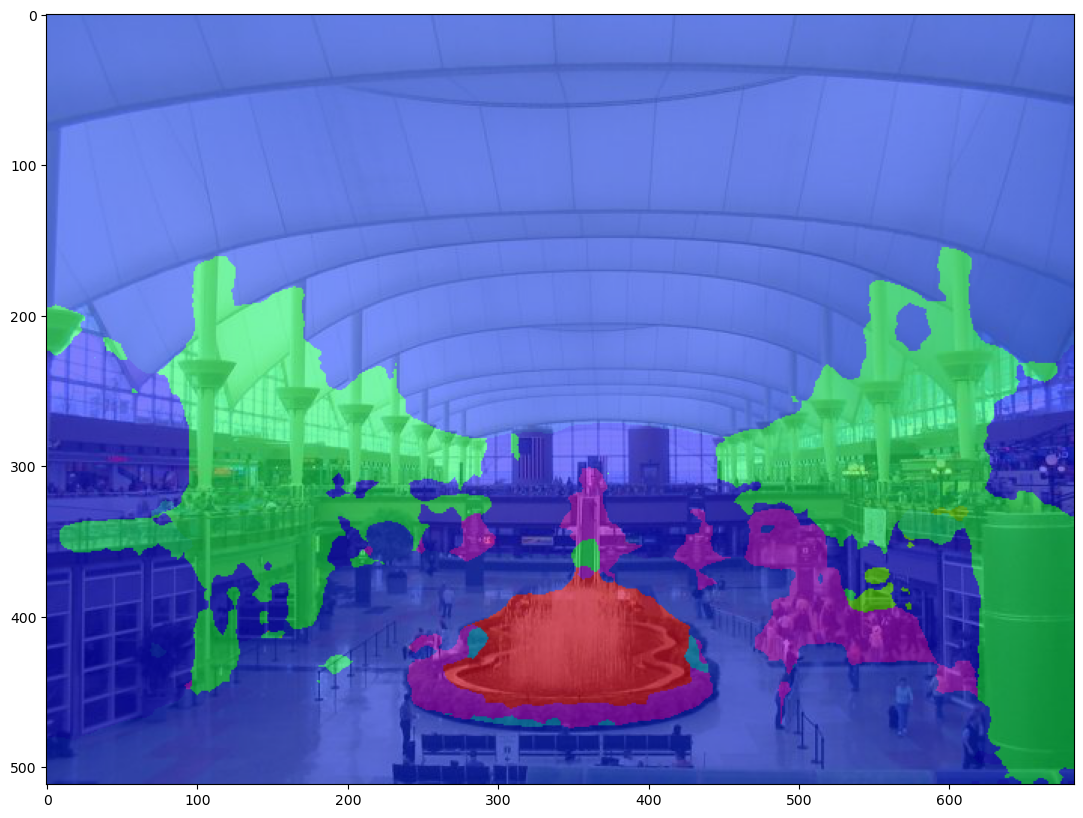

In [28]:
draw_segmentation(image_test_1, image_processor_1, model_1)

torch.Size([512, 683])


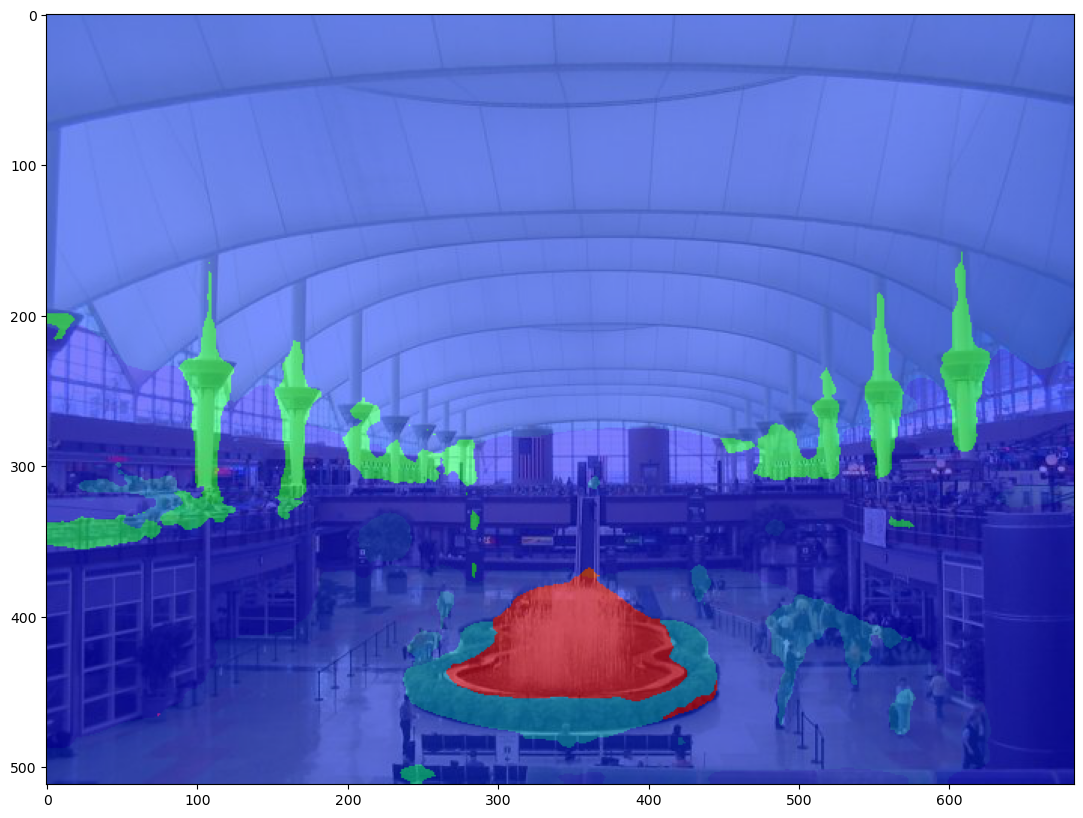

In [29]:
draw_segmentation(image_test_2, image_processor_2, model_2)

In [30]:
class NumpyEncoder(json.JSONEncoder):
    """ Special json encoder for numpy types """
    def default(self, obj):
        if isinstance(obj, np.integer):
            return int(obj)
        elif isinstance(obj, np.floating):
            return float(obj)
        elif isinstance(obj, np.ndarray):
            return obj.tolist()
        return json.JSONEncoder.default(self, obj)
    
def compute_metrics_complete(test_ds, image_processor, model, result_json):
    with torch.no_grad():
        results = {
            "mean_iou": [],
            "mean_accuracy": [],
            "overall_accuracy": [],
            "metrics_dice": []
        }
            
        for i, batch in enumerate(test_ds):
            #if i > 1: 
            #    break
            #print(batch.keys())
            #print(batch["pixel_values"].shape)
            if isinstance(model, MaskFormerForInstanceSegmentation):
                # Not working  
                encoding = image_processor(batch["pixel_values"], return_tensors="pt")
                pixel_values = encoding.pixel_values.to(model.device)
                pred = model(pixel_values=pixel_values)
                
                # Get ground truth semantic segmentation map
                annotation = np.array(test_ds1_annotation[i]) #[...,0]
                #print(annotation.shape)
                # Replace null class (0) with the ignore_index (255) and reduce labels
                annotation -= 1
                annotation[annotation==-1] = 255
                labels = annotation

                target_size = pixel_values.size()[::-1] #batch["pixel_values"].shape[::-1] 
                #print(target_size)
                result = image_processor.post_process_semantic_segmentation(pred)[0] #,target_sizes=[target_size]
                #semantic_seg_mask = result.cpu().detach().numpy()
                #print(result.size())
                #print(labels.shape[-2:])

                logits_tensor = nn.functional.interpolate(
                    result,
                    size=labels.shape[-2:],
                    mode="bilinear",
                    align_corners=False,
                ).argmax(dim=1)
                
                pred_labels = logits_tensor.cpu().detach().numpy()
            else:
                encoding = image_processor(batch["pixel_values"], return_tensors="pt")
                pixel_values = encoding.pixel_values.to(model.device)
                pred = model(pixel_values=pixel_values)
                logits = pred["logits"]
                #print(logits.size())
                labels = np.array([batch["labels"]])
                logits_tensor = logits
                logits_tensor = nn.functional.interpolate(
                    logits_tensor,
                    size=labels.shape[-2:],
                    mode="bilinear",
                    align_corners=False,
                ).argmax(dim=1)
                pred_labels = logits_tensor.detach().cpu().numpy()

            #print(labels)

            metrics_iou = metric_iou.compute(
                predictions=pred_labels,
                references=labels,
                num_labels=num_labels,
                ignore_index=255,
                reduce_labels=False,
            )
            metrics_dice = metric_dice(torch.from_numpy(pred_labels), torch.from_numpy(labels))
            metrics_dice = metrics_dice.detach().cpu().numpy()

            for key, value in metrics_iou.items():
                if type(value) is np.ndarray:
                    metrics_iou[key] = value.tolist()

            #print(metrics_iou)
            #print({'metrics_dice': metrics_dice})
            results["mean_iou"].append(metrics_iou["mean_iou"])
            results["mean_accuracy"].append(metrics_iou["mean_accuracy"])
            results["overall_accuracy"].append(metrics_iou["overall_accuracy"])
            results["metrics_dice"].append(metrics_dice)

        json_result = {
            "mean_iou": np.mean(np.array(results["mean_iou"])),
            "mean_accuracy": np.mean(np.array(results["mean_accuracy"])),
            "overall_accuracy": np.mean(np.array(results["overall_accuracy"])),
            "metrics_dice": np.mean(np.array(results["metrics_dice"]))
        }

        print(json_result)

        # Directly from dictionary
        with open(result_json, 'w', encoding='utf-8') as outfile:
            json.dump(json_result, outfile, ensure_ascii=False, indent=4, cls=NumpyEncoder)

In [31]:
compute_metrics_complete(test_ds1, image_processor_1, model_1, g_result_json_1)

C:\Users\User\.cache\huggingface\modules\evaluate_modules\metrics\evaluate-metric--mean_iou\08bc20f4f895f3caf75fb9e3fada1404bded3c3265243d05327cbb3b9326ffe9\mean_iou.py:259: RuntimeWarning: invalid value encountered in divide
  iou = total_area_intersect / total_area_union
C:\Users\User\.cache\huggingface\modules\evaluate_modules\metrics\evaluate-metric--mean_iou\08bc20f4f895f3caf75fb9e3fada1404bded3c3265243d05327cbb3b9326ffe9\mean_iou.py:260: RuntimeWarning: invalid value encountered in divide
  acc = total_area_intersect / total_area_label


{'mean_iou': 0.03819738547377278, 'mean_accuracy': 0.04653962841508155, 'overall_accuracy': 0.8326190669492333, 'metrics_dice': 0.79509455}


In [32]:
compute_metrics_complete(test_ds2, image_processor_2, model_2, g_result_json_2)

{'mean_iou': 0.41006483796434673, 'mean_accuracy': 0.5444512143253953, 'overall_accuracy': 0.7772612223859143, 'metrics_dice': 0.7473201}


In [33]:
def draw_segmentation_ensemble(image, image_processors, models):
    pred_sum = None

    for i in range(len(models)):
        encoding = image_processors[i](image, return_tensors="pt")
        pixel_values = encoding.pixel_values.to(models[i].device)
        outputs = models[i](pixel_values=pixel_values)
        logits = outputs.masks_queries_logits.cpu() if isinstance(models[i], MaskFormerForInstanceSegmentation) else outputs.logits.cpu() 
        
        upsampled_logits = nn.functional.interpolate(
            logits,
            size=image.size[::-1],
            mode="bilinear",
            align_corners=False,
        )

        pred_seg_subset = upsampled_logits.argmax(dim=1)[0]
        pred_sum = pred_seg_subset if pred_sum is None else pred_sum + pred_seg_subset
    
    #Naive elementise average
    pred_seg = (pred_sum / len(models)).to(torch.uint8)
    #print(pred_seg.min(), pred_seg.max())
    color_seg = np.zeros((pred_seg.shape[0], pred_seg.shape[1], 3), dtype=np.uint8)
    palette = np.array(create_ade20k_label_colormap())
    for label, color in enumerate(palette):
        color_seg[pred_seg == label, :] = color
    color_seg = color_seg[..., ::-1]  # convert to BGR

    img = np.array(image) * 0.5 + color_seg * 0.5  # plot the image with the segmentation map
    img = img.astype(np.uint8)

    plt.figure(figsize=(15, 10))
    plt.imshow(img)
    plt.show()

In [34]:
image_test_3 = ds[0]["image"]

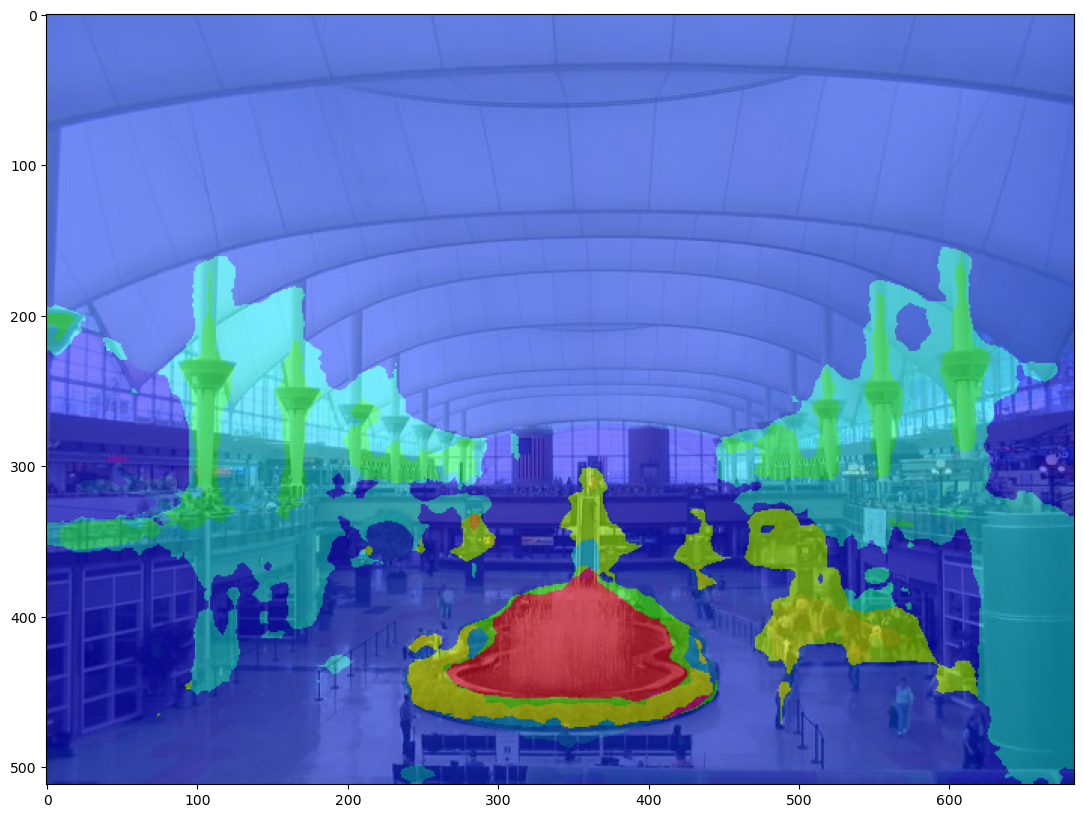

In [35]:
draw_segmentation_ensemble(image_test_3, [image_processor_1, image_processor_2], [model_1, model_2])

In [36]:
def compute_metrics_complete_ensemble(mappings, master_dataset, g_result_json):
    with torch.no_grad():
        results = {
            "mean_iou": [],
            "mean_accuracy": [],
            "overall_accuracy": [],
            "metrics_dice": []
        }
            
        for i, batch_master in enumerate(master_dataset):
            #if i > 0: 
            #    break
            #print(batch.keys())
            #print(batch["pixel_values"].shape)
            label_master = batch_master["labels"]
            labels = np.array([label_master])
            pred_labels_sum = None

            for mapping in mappings:
                image_processor = mapping["image_processor"]
                model = mapping["model"]
                test_ds = mapping["test_ds"]

                encoding = image_processor(test_ds[i]["pixel_values"], return_tensors="pt")
                pixel_values = encoding.pixel_values.to(model.device)
                pred = model(pixel_values=pixel_values)
                logits = pred["logits"]
                #print(logits.size())                
                logits_tensor = logits
                logits_tensor = nn.functional.interpolate(
                    logits_tensor,
                    size=labels.shape[-2:],
                    mode="bilinear",
                    align_corners=False,
                ).argmax(dim=1)
                pred_labels_single = logits_tensor.detach().cpu().numpy()
                print(pred_labels_single.shape)        
                pred_labels_sum = pred_labels_single if pred_labels_sum is None else pred_labels_sum + pred_labels_single

            #print(labels)
            pred_labels = (pred_labels_sum / len(mappings)).astype(np.uint8)

            metrics_iou = metric_iou.compute(
                predictions=pred_labels,
                references=labels,
                num_labels=num_labels,
                ignore_index=255,
                reduce_labels=False,
            )
            metrics_dice = metric_dice(torch.from_numpy(pred_labels), torch.from_numpy(labels))
            metrics_dice = metrics_dice.detach().cpu().numpy()

            for key, value in metrics_iou.items():
                if type(value) is np.ndarray:
                    metrics_iou[key] = value.tolist()

            #print(metrics_iou)
            #print({'metrics_dice': metrics_dice})
            results["mean_iou"].append(metrics_iou["mean_iou"])
            results["mean_accuracy"].append(metrics_iou["mean_accuracy"])
            results["overall_accuracy"].append(metrics_iou["overall_accuracy"])
            results["metrics_dice"].append(metrics_dice)

        json_result = {
            "mean_iou": np.mean(np.array(results["mean_iou"])),
            "mean_accuracy": np.mean(np.array(results["mean_accuracy"])),
            "overall_accuracy": np.mean(np.array(results["overall_accuracy"])),
            "metrics_dice": np.mean(np.array(results["metrics_dice"]))
        }

        print(json_result)

        # Directly from dictionary
        with open(g_result_json, 'w', encoding='utf-8') as outfile:
            json.dump(json_result, outfile, ensure_ascii=False, indent=4, cls=NumpyEncoder)

In [37]:
compute_metrics_complete_ensemble(mappings = [{
    "test_ds": test_ds1,
    "image_processor": image_processor_1,
    "model": model_1
},{
    "test_ds": test_ds2,
    "image_processor": image_processor_2,
    "model": model_2
}], master_dataset=test_ds2, g_result_json=g_result_json_3)

(1, 640, 640)
(1, 640, 640)
(1, 640, 640)
(1, 640, 640)
(1, 640, 640)
(1, 640, 640)
(1, 640, 640)
(1, 640, 640)
(1, 640, 640)
(1, 640, 640)
(1, 640, 640)
(1, 640, 640)
(1, 640, 640)
(1, 640, 640)
(1, 640, 640)
(1, 640, 640)
(1, 640, 640)
(1, 640, 640)
(1, 640, 640)
(1, 640, 640)
(1, 640, 640)
(1, 640, 640)
(1, 640, 640)
(1, 640, 640)
(1, 640, 640)
(1, 640, 640)
(1, 640, 640)
(1, 640, 640)
(1, 640, 640)
(1, 640, 640)
(1, 640, 640)
(1, 640, 640)
(1, 640, 640)
(1, 640, 640)
(1, 640, 640)
(1, 640, 640)
(1, 640, 640)
(1, 640, 640)
(1, 640, 640)
(1, 640, 640)
(1, 640, 640)
(1, 640, 640)
(1, 640, 640)
(1, 640, 640)
(1, 640, 640)
(1, 640, 640)
(1, 640, 640)
(1, 640, 640)
(1, 640, 640)
(1, 640, 640)
(1, 640, 640)
(1, 640, 640)
(1, 640, 640)
(1, 640, 640)
(1, 640, 640)
(1, 640, 640)
(1, 640, 640)
(1, 640, 640)
(1, 640, 640)
(1, 640, 640)
(1, 640, 640)
(1, 640, 640)
(1, 640, 640)
(1, 640, 640)
(1, 640, 640)
(1, 640, 640)
(1, 640, 640)
(1, 640, 640)
(1, 640, 640)
(1, 640, 640)
(1, 640, 640)
(1, 64